In [26]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice
optuna.logging.set_verbosity(optuna.logging.ERROR) # Suppress verbose logs

# Preprocessing and Model Selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight

# Metrics & Plotting Tools
from sklearn.metrics import (roc_auc_score, f1_score, matthews_corrcoef, balanced_accuracy_score,
                             precision_score, recall_score, roc_curve, auc,
                             confusion_matrix, precision_recall_curve)

# Model Explanation
import shap

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def make_weights(y):
    classes = np.array([0, 1])
    cw = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    class_weights = {0: cw[0], 1: cw[1]}
    sample_weight = y.map(class_weights).to_numpy()
    # also handy for XGBoosts scale_pos_weight:
    neg, pos = (y==0).sum(), (y==1).sum()
    spw = neg / pos if pos > 0 else 1.0
    return class_weights, sample_weight, spw

In [28]:
def compute_all_metrics(y_true, y_pred, y_pred_prob):
    """Computes a dictionary of key classification metrics."""
    metrics = {
        'ROC AUC': roc_auc_score(y_true, y_pred_prob),
        'MCC': matthews_corrcoef(y_true, y_pred), # MCC added
        'F1 Score': f1_score(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
    }
    return {k: round(v, 4) for k, v in metrics.items()}

def plot_confusion_matrix_heatmap(y_true, y_pred, model_name):
    """Generates and displays a confusion matrix heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Benign (0)', 'Predicted Pathogenic (1)'],
                yticklabels=['Actual Benign (0)', 'Actual Pathogenic (1)'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

def plot_precision_recall_curves(all_model_preds, y_true):
    """Plots Precision-Recall curves for all models on one chart."""
    plt.figure(figsize=(10, 8))
    for name, data in all_model_preds.items():
        precision, recall, _ = precision_recall_curve(y_true, data['y_pred_prob'])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=2, label=f"{name} (PR AUC = {pr_auc:.3f})")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

In [29]:
def find_best_threshold_f1(y_true, y_prob):
    """Return threshold that maximizes F1 on a validation set."""
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    # thresholds length is len(prec)-1
    f1 = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    i = np.nanargmax(f1)
    return float(thr[i]), float(f1[i])

def find_threshold_for_target_precision(y_true, y_prob, target=0.90):
    """Highest threshold that achieves at least `target` precision (returns (thr, precision))."""
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    ok = np.where(prec[:-1] >= target)[0]
    if len(ok) == 0:
        return 0.5, None
    i = ok[np.argmax(rec[:-1][ok])]
    return float(thr[i]), float(prec[i])

In [30]:
def find_best_threshold_mcc(y_true, y_prob):
    """
    Return threshold that maximizes MCC on a validation set.
    Robust to class imbalance; scans unique score cutoffs.
    """
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob)

    # scan unique cutoffs + endpoints
    thresholds = np.r_[0.0, np.sort(np.unique(y_prob)), 1.0]

    best_thr, best_mcc = 0.5, -np.inf
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        # compute MCC from confusion counts (stable if a term is zero)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        num = tp * tn - fp * fn
        den = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        mcc = num / den if den > 0 else 0.0
        if mcc > best_mcc:
            best_mcc, best_thr = mcc, t
    return float(best_thr), float(best_mcc)

In [ ]:
def lgbm_objective(trial, X, y, preprocessor):
    """Objective function for LightGBM tuning."""
    # Split data for validation within the objective
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Preprocess the data splits
    X_train_processed = preprocessor.fit_transform(X_train, y_train)
    # Use the same preprocessor for validation data
    X_val_processed = preprocessor.transform(X_val)

    class_weights, sw_train, _ = make_weights(y_train)

    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': 1000,
        'class_weight': class_weights,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    }

    model = LGBMClassifier(**params, random_state=42)
    model.fit(X_train_processed, y_train,
              sample_weight=sw_train,
              eval_set=[(X_val_processed, y_val)],
              eval_metric='auc',
              callbacks=[optuna.integration.LightGBMPruningCallback(trial, 'auc')])

    preds_proba = model.predict_proba(X_val_processed)[:, 1]
    return roc_auc_score(y_val, preds_proba)

def xgb_objective(trial, X, y, preprocessor):
    """Objective function for XGBoost tuning."""
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    X_train_processed = preprocessor.fit_transform(X_train, y_train)
    # Use the same preprocessor for validation data
    X_val_processed = preprocessor.transform(X_val)

    _, sw_train, scale_pos_weight = make_weights(y_train)

    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'scale_pos_weight': scale_pos_weight,
        'eta': trial.suggest_float('eta', 1e-3, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
    }

    model = xgb.XGBClassifier(**params, n_estimators=1000, use_label_encoder=False, random_state=42)
    model.fit(X_train_processed, y_train,
              sample_weight=sw_train,
              eval_set=[(X_val_processed, y_val)],
              verbose=False)

    preds_proba = model.predict_proba(X_val_processed)[:, 1]
    return roc_auc_score(y_val, preds_proba)

def catboost_objective(trial, X, y, preprocessor):
    """Objective function for CatBoost tuning."""
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    X_train_processed = preprocessor.fit_transform(X_train, y_train)
    # Use the same preprocessor for validation data
    X_val_processed = preprocessor.transform(X_val)

    class_weights, sw_train, _ = make_weights(y_train)

    params = {
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'iterations': 1000,
        'class_weights': [class_weights[0], class_weights[1]], 
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'depth': trial.suggest_int('depth', 3, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
    }

    model = CatBoostClassifier(**params, random_state=42, verbose=0)
    model.fit(X_train_processed, y_train,
              sample_weight=sw_train,                     
              eval_set=[(X_val_processed, y_val)],
              early_stopping_rounds=50,
              verbose=False)

    preds_proba = model.predict_proba(X_val_processed)[:, 1]
    return roc_auc_score(y_val, preds_proba)

In [32]:
import math, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_random_state

def _log_gaussian(x, mu, sigma):
    # elementwise log N(x | mu, sigma^2)
    return -0.5*math.log(2*math.pi) - torch.log(sigma) - 0.5*((x - mu)/sigma)**2

def _log_scale_mixture_prior(w, pi, s1, s2):
    logN1 = _log_gaussian(w, 0.0, s1)
    logN2 = _log_gaussian(w, 0.0, s2)
    logpi, log1m = torch.log(pi+1e-12), torch.log(1-pi+1e-12)
    return torch.logsumexp(torch.stack([logpi+logN1, log1m+logN2], 0), dim=0)

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, *, prior_pi=0.5, prior_sigma1=1.0, prior_sigma2=0.1):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # variational params
        self.weight_mu  = nn.Parameter(torch.empty(out_features, in_features).normal_(0, 0.05))
        self.weight_rho = nn.Parameter(torch.full((out_features, in_features), -5.0))
        self.bias_mu    = nn.Parameter(torch.zeros(out_features))
        self.bias_rho   = nn.Parameter(torch.full((out_features,), -5.0))

        # fixed prior hyperparams
        self.register_buffer('prior_pi', torch.tensor(prior_pi, dtype=torch.float32))
        self.register_buffer('prior_sigma1', torch.tensor(prior_sigma1, dtype=torch.float32))
        self.register_buffer('prior_sigma2', torch.tensor(prior_sigma2, dtype=torch.float32))

    def _sigma(self, rho):
        # softplus to ensure positivity; numerically stable
        return F.softplus(rho)

    def forward(self, x, sample=True):
        # sample weights (reparameterization) once per forward
        if self.training or sample:
            eps_w = torch.randn_like(self.weight_mu)
            eps_b = torch.randn_like(self.bias_mu)
            weight_sigma = self._sigma(self.weight_rho)
            bias_sigma   = self._sigma(self.bias_rho)
            weight = self.weight_mu + weight_sigma * eps_w
            bias   = self.bias_mu   + bias_sigma   * eps_b
        else:
            weight = self.weight_mu
            bias   = self.bias_mu

        out = F.linear(x, weight, bias)

        # accumulate log q and log p for the KL term
        weight_sigma = self._sigma(self.weight_rho)
        bias_sigma   = self._sigma(self.bias_rho)

        log_q_w = _log_gaussian(weight, self.weight_mu, weight_sigma).sum()
        log_q_b = _log_gaussian(bias,   self.bias_mu,   bias_sigma).sum()
        log_q = log_q_w + log_q_b

        log_p_w = _log_scale_mixture_prior(weight, self.prior_pi, self.prior_sigma1, self.prior_sigma2).sum()
        log_p_b = _log_scale_mixture_prior(bias,   self.prior_pi, self.prior_sigma1, self.prior_sigma2).sum()
        log_p = log_p_w + log_p_b

        return out, log_q, log_p

class BayesMLP(nn.Module):
    def __init__(self, in_dim, hidden_sizes=(128,128),
                 prior_pi=0.5, prior_sigma1=1.0, prior_sigma2=0.1):
        super().__init__()
        layers = []
        last = in_dim
        self.blayers = nn.ModuleList()
        for h in hidden_sizes:
            bl = BayesianLinear(last, h, prior_pi=prior_pi, prior_sigma1=prior_sigma1, prior_sigma2=prior_sigma2)
            self.blayers.append(bl)
            last = h
        self.out = BayesianLinear(last, 1, prior_pi=prior_pi, prior_sigma1=prior_sigma1, prior_sigma2=prior_sigma2)

    def forward(self, x, sample=True):
        log_q_total = 0.0
        log_p_total = 0.0
        for bl in self.blayers:
            x, lq, lp = bl(x, sample=sample)
            log_q_total = log_q_total + lq
            log_p_total = log_p_total + lp
            x = F.relu(x)
        logits, lq, lp = self.out(x, sample=sample)
        log_q_total = log_q_total + lq
        log_p_total = log_p_total + lp
        return logits.squeeze(-1), log_q_total, log_p_total  # logits, scalars


In [ ]:
class BayesByBackpropClassifier(BaseEstimator, ClassifierMixin):
    """
    Binary classifier using Bayes by Backprop (Blundell et al., 2015).
    - Variational posterior: diagonal Gaussian per weight (mu, rho).
    - Prior: scale mixture of two zero-mean Gaussians (pi, sigma1, sigma2).
    - Loss: (log q - log p) reweighted per minibatch + BCE-with-logits likelihood.
    """
    def __init__(self,
                 hidden_sizes=(128, 128),
                 prior_pi=0.5, prior_sigma1=1.0, prior_sigma2=0.1,
                 epochs=150, batch_size=128, lr=1e-3, weight_decay=0.0,
                 kl_anneal=True, device=None, n_mc_predict=20,
                 class_weight='balanced', random_state=42, verbose=False):
        self.hidden_sizes = tuple(hidden_sizes)
        self.prior_pi = float(prior_pi)
        self.prior_sigma1 = float(prior_sigma1)
        self.prior_sigma2 = float(prior_sigma2)
        self.epochs = int(epochs)
        self.batch_size = int(batch_size)
        self.lr = float(lr)
        self.weight_decay = float(weight_decay)
        self.kl_anneal = bool(kl_anneal)
        self.n_mc_predict = int(n_mc_predict)
        self.class_weight = class_weight  # 'balanced' | None | {0:w0, 1:w1}
        self.random_state = int(random_state)
        self.verbose = bool(verbose)
        self.device = device  # 'cuda' | 'cpu' | None

        # placeholders
        self._net = None
        self._in_dim = None
        self._classes_ = np.array([0,1])

    def _resolve_device(self):
        if self.device is not None:
            return torch.device(self.device)
        return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def _prepare_weights(self, y):
        y = np.asarray(y).astype(int)
        if isinstance(self.class_weight, dict):
            cw = self.class_weight
        elif self.class_weight == 'balanced':
            neg, pos = (y==0).sum(), (y==1).sum()
            total = neg + pos
            w0 = total/(2.0*neg) if neg>0 else 0.0
            w1 = total/(2.0*pos) if pos>0 else 0.0
            cw = {0:w0, 1:w1}
        else:
            cw = {0:1.0, 1:1.0}
        sample_w = np.where(y==1, cw[1], cw[0]).astype(np.float32)
        return cw, sample_w

    def fit(self, X, y):
        rs = check_random_state(self.random_state)
        torch.manual_seed(self.random_state)
        self._in_dim = X.shape[1]
        dev = self._resolve_device()

        X_np = np.asarray(X, dtype=np.float32)
        y_np = np.asarray(y, dtype=np.float32).ravel()
        class_w, sample_w = self._prepare_weights(y_np)

        # tensors
        X_tensor = torch.from_numpy(X_np)
        y_tensor = torch.from_numpy(y_np)
        w_tensor = torch.from_numpy(sample_w)

        dataset = TensorDataset(X_tensor, y_tensor, w_tensor)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, drop_last=False)

        self._net = BayesMLP(self._in_dim, self.hidden_sizes,
                             prior_pi=self.prior_pi, prior_sigma1=self.prior_sigma1, prior_sigma2=self.prior_sigma2).to(dev)
        opt = torch.optim.Adam(self._net.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        num_batches = max(1, math.ceil(len(dataset)/self.batch_size))

        for epoch in range(self.epochs):
            self._net.train()
            total_loss = 0.0
            # simple linear KL annealing across epochs (or disable)
            kl_scale_epoch = (epoch+1)/self.epochs if self.kl_anneal else 1.0

            for xb, yb, wb in loader:
                xb = xb.to(dev, non_blocking=True)
                yb = yb.to(dev, non_blocking=True)
                wb = wb.to(dev, non_blocking=True)

                opt.zero_grad()
                logits, log_q, log_p = self._net(xb, sample=True)

                # BCE with logits, sample-weighted
                bce = F.binary_cross_entropy_with_logits(logits, yb, reduction='none')
                bce = (bce * wb).sum()

                # minibatch KL weighting (approx. Eq. 8/9; here 1/num_batches)
                kl = (log_q - log_p) * (kl_scale_epoch / num_batches)

                loss = bce + kl
                loss.backward()
                opt.step()

                total_loss += loss.item()

            if self.verbose and ((epoch+1) % max(1, self.epochs//10) == 0):
                print(f"[BNN] Epoch {epoch+1}/{self.epochs} - loss {total_loss/num_batches:.4f}")

        self.device_ = str(dev)
        return self

    def predict_proba(self, X):
        if self._net is None:
            raise RuntimeError("Model not fitted.")
        dev = self._resolve_device()
        self._net.eval()
        X_np = np.asarray(X, dtype=np.float32)
        X_tensor = torch.from_numpy(X_np).to(dev)

        # MC average of predictive probabilities
        with torch.no_grad():
            probs = []
            for _ in range(self.n_mc_predict):
                logits, _, _ = self._net(X_tensor, sample=True)
                probs.append(torch.sigmoid(logits).cpu().numpy())
            p_mean = np.mean(probs, axis=0)
        p_mean = np.clip(p_mean, 1e-7, 1-1e-7)
        return np.column_stack([1.0 - p_mean, p_mean])

    def predict(self, X):
        proba = self.predict_proba(X)[:,1]
        return (proba >= 0.5).astype(int)

    # sklearn compatibility
    def get_params(self, deep=True):
        return {k:getattr(self,k) for k in (
            "hidden_sizes","prior_pi","prior_sigma1","prior_sigma2",
            "epochs","batch_size","lr","weight_decay","kl_anneal",
            "device","n_mc_predict","class_weight","random_state","verbose"
        )}

    def set_params(self, **params):
        for k,v in params.items():
            setattr(self,k,v)
        return self


In [34]:
def _one_hot_base(b):
    # A, C, G, T; else N
    bases = ['A','C','G','T']
    return [1 if b==bb else 0 for bb in bases]

def _is_transition(ref, alt):
    pur = set(['A','G']); pyr = set(['C','T'])
    if ref in pur and alt in pur: return 1
    if ref in pyr and alt in pyr: return 1
    return 0

class SequenceContextEncoder(BaseEstimator, TransformerMixin):
    """Deterministic, leak-free encoder for nucleotide_context (5-mer) and wt_mut_transition (XYZ>ABC)."""
    def __init__(self, nuc_col='nucleotide_context', wtmut_col='wt_mut_transition'):
        self.nuc_col = nuc_col
        self.wtmut_col = wtmut_col
        self.out_columns_ = None

    def fit(self, X, y=None):
        # define output column names deterministically
        cols = []
        if self.nuc_col in X.columns:
            # 5 positions × 4 bases
            for i in range(5):
                for b in ['A','C','G','T']:
                    cols.append(f"{self.nuc_col}_pos{i+1}_{b}")
            cols += [f"{self.nuc_col}_GC_count", f"{self.nuc_col}_has_CpG"]
        if self.wtmut_col in X.columns:
            # changed position 1..3
            cols += [f"{self.wtmut_col}_chgpos_{i}" for i in [1,2,3]]
            # substitution type collapsed to 6 (pyrimidine-oriented)
            for sub in ["C>A","C>G","C>T","T>A","T>C","T>G"]:
                cols.append(f"{self.wtmut_col}_sub_{sub}")
            cols.append(f"{self.wtmut_col}_is_transition")
            # central ref base one-hot
            for b in ['A','C','G','T']:
                cols.append(f"{self.wtmut_col}_center_ref_{b}")
            # CpG presence before/after (in 3-mer scope)
            cols += [f"{self.wtmut_col}_has_CpG_before", f"{self.wtmut_col}_has_CpG_after"]
            # multi-position change flag
            cols.append(f"{self.wtmut_col}_multi_change")
        self.out_columns_ = cols
        return self

    def transform(self, X):
        out = []
        n = len(X)
        # init zeros
        Z = np.zeros((n, len(self.out_columns_)), dtype=float)
        col_idx = {c:i for i,c in enumerate(self.out_columns_)}
        # nucleotide_context
        if self.nuc_col in X.columns:
            nuc_vals = X[self.nuc_col].astype(str).fillna("")
            for i, s in enumerate(nuc_vals):
                s = s.upper()
                if len(s) != 5:
                    # pad/truncate
                    s = (s+"NNNNN")[:5]
                # position one-hots
                for pos in range(5):
                    b = s[pos] if s[pos] in ['A','C','G','T'] else 'N'
                    if b in ['A','C','G','T']:
                        Z[i, col_idx[f"{self.nuc_col}_pos{pos+1}_{b}"]] = 1
                # GC count
                gc = sum(1 for ch in s if ch in ['G','C'])
                Z[i, col_idx[f"{self.nuc_col}_GC_count"]] = gc
                # CpG presence (within the 5-mer)
                Z[i, col_idx[f"{self.nuc_col}_has_CpG"]] = 1 if 'CG' in s else 0

        # wt_mut_transition
        if self.wtmut_col in X.columns:
            wt_vals = X[self.wtmut_col].astype(str).fillna("")
            for i, t in enumerate(wt_vals):
                t = t.upper()
                if '>' not in t:
                    continue
                left, right = t.split('>', 1)
                left = (left+"NNN")[:3]; right = (right+"NNN")[:3]
                # changed position flags
                diffs = [int(left[p]!=right[p]) for p in range(3) if left[p] in 'ACGT' and right[p] in 'ACGT']
                multi_change = 1 if sum(diffs) != 1 else 0
                if not multi_change:
                    chgpos = [p for p in range(3) if left[p] != right[p]][0]
                    Z[i, col_idx[f"{self.wtmut_col}_chgpos_{chgpos+1}"]] = 1
                    ref = left[chgpos]; alt = right[chgpos]
                    # central ref one-hot (center = position 2)
                    if left[1] in ['A','C','G','T']:
                        Z[i, col_idx[f"{self.wtmut_col}_center_ref_{left[1]}"]] = 1
                    # transition vs transversion
                    Z[i, col_idx[f"{self.wtmut_col}_is_transition"]] = _is_transition(ref, alt)
                    # pyrimidine-oriented 6-class: map complements to C or T ref
                    # normalize to pyrimidine ref
                    comp = {'A':'T','C':'G','G':'C','T':'A'}
                    r = ref; a = alt
                    if r in ['A','G']:  # purine → take complement
                        r = comp[r]; a = comp[a]
                    key = f"{r}>{a}"
                    if key in ["C>A","C>G","C>T","T>A","T>C","T>G"]:
                        Z[i, col_idx[f"{self.wtmut_col}_sub_{key}"]] = 1
                else:
                    Z[i, col_idx[f"{self.wtmut_col}_multi_change"]] = 1
                # CpG before/after within 3-mer proxy
                Z[i, col_idx[f"{self.wtmut_col}_has_CpG_before"]] = 1 if 'CG' in left else 0
                Z[i, col_idx[f"{self.wtmut_col}_has_CpG_after"]]  = 1 if 'CG' in right else 0

        return pd.DataFrame(Z, index=X.index, columns=self.out_columns_)

In [35]:
feature_list = pd.read_csv("feature_sets_large_study/pls_representative_features.csv")["feature"].tolist()
cosmic_df = pd.read_csv("train_set_10.4k.csv")

In [37]:
y = cosmic_df["pathogenicity_label"]
X_raw = cosmic_df.drop(columns=["pathogenicity_label"])

In [38]:
y.value_counts()

pathogenicity_label
1    5299
0    5071
Name: count, dtype: int64

In [39]:
X_raw.shape

(10370, 974)

In [ ]:
seqenc = SequenceContextEncoder(nuc_col='nucleotide_context', wtmut_col='wt_mut_transition')
seqenc.fit(X_raw)                          # deterministic, no leakage concerns
seq_encoded = seqenc.transform(X_raw)

In [13]:
X_feat = X_raw.drop(columns=['nucleotide_context','wt_mut_transition'], errors='ignore')
X_feat = pd.concat([X_feat, seq_encoded], axis=1)

In [14]:
X_feat = X_feat.loc[:, [c for c in feature_list if c in X_feat.columns]]

In [15]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_feat, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
tf_zero_cols = [c for c in ['tf_count','tf_score_min','tf_score_med','tf_score_max'] if c in X_train_raw.columns]
num_other     = [c for c in X_train_raw.select_dtypes(include=np.number).columns if c not in tf_zero_cols]

num_other_pipe = Pipeline([('imputer', SimpleImputer(strategy='median'))])
tf_zero_pipe   = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=0))])

In [ ]:
pre = ColumnTransformer(
    transformers=[
        ('num_other', num_other_pipe, num_other),
        ('tf_zero',  tf_zero_pipe,   tf_zero_cols),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

pp = Pipeline([
    ('ct', pre),
    ('scaler', StandardScaler())
])

In [18]:
keep_cols = [c for c in feature_list if c in X_feat.columns]
missing = sorted(set(feature_list) - set(keep_cols))
if missing:
    print(f"[Info] {len(missing)} PLS features not present post-encoding (e.g. first 8): {missing[:8]}")
X_feat = X_feat[keep_cols].copy()


In [19]:
X_train_proc = pp.fit_transform(X_train_raw, y_train)
X_test_proc  = pp.transform(X_test_raw)

In [20]:
proc_cols = pp.named_steps['ct'].get_feature_names_out().tolist()

In [21]:
X_train = pd.DataFrame(X_train_proc, columns=proc_cols, index=X_train_raw.index)
X_test  = pd.DataFrame(X_test_proc,  columns=proc_cols, index=X_test_raw.index)

print("Train/Test shapes after preprocessing:", X_train.shape, X_test.shape)

Train/Test shapes after preprocessing: (443, 57) (111, 57)


In [36]:
print("X_train features:", list(X_train_raw.columns))
print("Number of features in X_train:", len(X_train_raw.columns))

print("\nX_test features:", list(X_test_raw.columns))
print("Number of features in X_test:", len(X_test_raw.columns))

X_train features: ['nma_msf10_10', 'gerp_rs', 'phyloP100way_score', 'pos', 'nucleotide_context_pos1_T', 'nucleotide_context_pos4_C', 'wt_mut_transition_has_CpG_before', 'wt_mut_transition_chgpos_3', 'nucleotide_context_has_CpG', 'phastCons100way_score', 'wt_mut_transition_chgpos_2', 'tf_count', 'nucleotide_context_pos3_C', 'wt_mut_transition_is_transition', 'sap_12', 'sasa_total', 'nucleotide_context_pos5_A', 'tf_score_max', 'nucleotide_context_pos5_C', 'nucleotide_context_pos4_T', 'nucleotide_context_pos1_G', 'wt_mut_transition_center_ref_T', 'wt_mut_transition_sub_C>A', 'nucleotide_context_pos4_G', 'nucleotide_context_pos4_A', 'propy__SecondaryStrC1', 'wt_mut_transition_sub_C>T', 'nucleotide_context_pos3_T', 'nucleotide_context_pos2_C', 'nucleotide_context_pos5_G', 'esm2_delta', 'wt_mut_transition_sub_T>A', 'gerp_nr', 'nucleotide_context_pos5_T', 'blosum80', 'wt_mut_transition_chgpos_1', 'propy__PolarityC2', 'wt_mut_transition_center_ref_C', 'nucleotide_context_pos2_G', 'propy__Charg

In [37]:
Xtr_proc_thr, Xval_proc_thr, ytr_thr, yval_thr = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)
Xtr_raw_thr,  Xval_raw_thr,  ytr_raw,  yval_raw  = train_test_split(
    X_train_raw, y_train, test_size=0.2, stratify=y_train, random_state=42
)

In [38]:
models_to_tune = {
    'XGBoost': (xgb.XGBClassifier, xgb_objective),
    'LightGBM': (LGBMClassifier, lgbm_objective),
    'CatBoost': (CatBoostClassifier, catboost_objective)
}

In [39]:
all_model_predictions = {}
results = []
fitted_models = {}
optuna_studies = {}
best_thresholds = {}

In [40]:
cw, sw_train_baseline, _ = make_weights(y_train)

In [41]:
baseline_models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced',
                                              random_state=42, max_iter=2000),
    'Naive Bayes': GaussianNB(),
    'Bayesian NN': BayesByBackpropClassifier(
        hidden_sizes=(256,128),
        prior_pi=0.5, prior_sigma1=1.0, prior_sigma2=0.1,
        epochs=200, batch_size=128, lr=1e-3, kl_anneal=True,
        n_mc_predict=100,
        class_weight='balanced',
        random_state=42, verbose=False
    )
}

In [42]:
for name, model in baseline_models.items():
    print(f"Evaluating baseline: {name}")
    if name == 'Naive Bayes':
        model.fit(X_train, y_train, sample_weight=sw_train_baseline)
    else:
        model.fit(X_train, y_train)

    val_prob = model.predict_proba(Xval_proc_thr)[:, 1]
    thr, mccv = find_best_threshold_mcc(yval_thr, val_prob)
    best_thresholds[name] = thr
    print(f"{name}: MCC threshold on val = {thr:.3f} (MCC={mccv:.3f})")

    test_prob = model.predict_proba(X_test)[:, 1]
    test_pred = (test_prob >= thr).astype(int)

    all_model_predictions[name] = {'y_pred_prob': test_prob, 'y_pred': test_pred}
    fitted_models[name] = model

Evaluating baseline: Logistic Regression
Logistic Regression: MCC threshold on val = 0.324 (MCC=0.536)
Evaluating baseline: Naive Bayes
Naive Bayes: MCC threshold on val = 0.981 (MCC=0.342)
Evaluating baseline: Bayesian NN
Bayesian NN: MCC threshold on val = 0.446 (MCC=0.632)


In [ ]:
for name, (model_class, objective_func) in models_to_tune.items():
    print(f"\n--- Tuning {name} ---")
    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
    study.optimize(lambda trial: objective_func(trial, X_train, y_train, pre), n_trials=10)

    final_model = model_class(**study.best_params, random_state=42)
    if name == 'CatBoost': final_model.set_params(verbose=0)

    pipeline = Pipeline(steps=[('preprocessor', pre), ('classifier', final_model)])
    pipeline.fit(X_train_raw, y_train)  # fit on RAW

    val_prob = pipeline.predict_proba(Xval_raw_thr)[:, 1]
    thr, mccv  = find_best_threshold_mcc(yval_raw, val_prob)
    best_thresholds[name] = thr
    print(f"{name}: MCC threshold on val = {thr:.3f} (MCC={mccv:.3f})")

    test_prob = pipeline.predict_proba(X_test_raw)[:, 1]
    test_pred = (test_prob >= thr).astype(int)

    all_model_predictions[name] = {
        'y_pred_prob': test_prob,
        'y_pred': test_pred,
    }
    fitted_models[name] = pipeline
    optuna_studies[name] = study
    print(f"Finished tuning {name}. Best validation AUC: {study.best_value:.4f}")


--- Tuning XGBoost ---
XGBoost: MCC threshold on val = 0.734 (MCC=0.955)
Finished tuning XGBoost. Best validation AUC: 0.6310

--- Tuning LightGBM ---
LightGBM: MCC threshold on val = 0.624 (MCC=1.000)
Finished tuning LightGBM. Best validation AUC: 0.6926

--- Tuning CatBoost ---
CatBoost: MCC threshold on val = 1.000 (MCC=1.000)
Finished tuning CatBoost. Best validation AUC: 0.6364


In [44]:
for name, preds in all_model_predictions.items():
    model_metrics = compute_all_metrics(y_test, preds['y_pred'], preds['y_pred_prob'])
    model_metrics['Model'] = name
    results.append(model_metrics)

results_df = pd.DataFrame(results).set_index('Model')

results_df = results_df[['ROC AUC', 'MCC', 'F1 Score', 'Balanced Accuracy', 'Precision', 'Recall']]

print("\n\n--- Model Performance Comparison on Test Set ---")
print(results_df.sort_values(by='ROC AUC', ascending=False))



--- Model Performance Comparison on Test Set ---
                     ROC AUC     MCC  F1 Score  Balanced Accuracy  Precision  \
Model                                                                          
Naive Bayes           0.6264  0.1048    0.5714             0.5750     0.9091   
Bayesian NN           0.6215  0.1557    0.8114             0.6031     0.8987   
CatBoost              0.5875  0.0326    0.7425             0.5229     0.8732   
Logistic Regression   0.5563  0.0738    0.8156             0.5469     0.8795   
XGBoost               0.5396  0.1386    0.9154             0.5458     0.8762   
LightGBM              0.5285  0.0412    0.9109             0.5125     0.8679   

                     Recall  
Model                        
Naive Bayes          0.4167  
Bayesian NN          0.7396  
CatBoost             0.6458  
Logistic Regression  0.7604  
XGBoost              0.9583  
LightGBM             0.9583  




--- Performance Visualizations ---


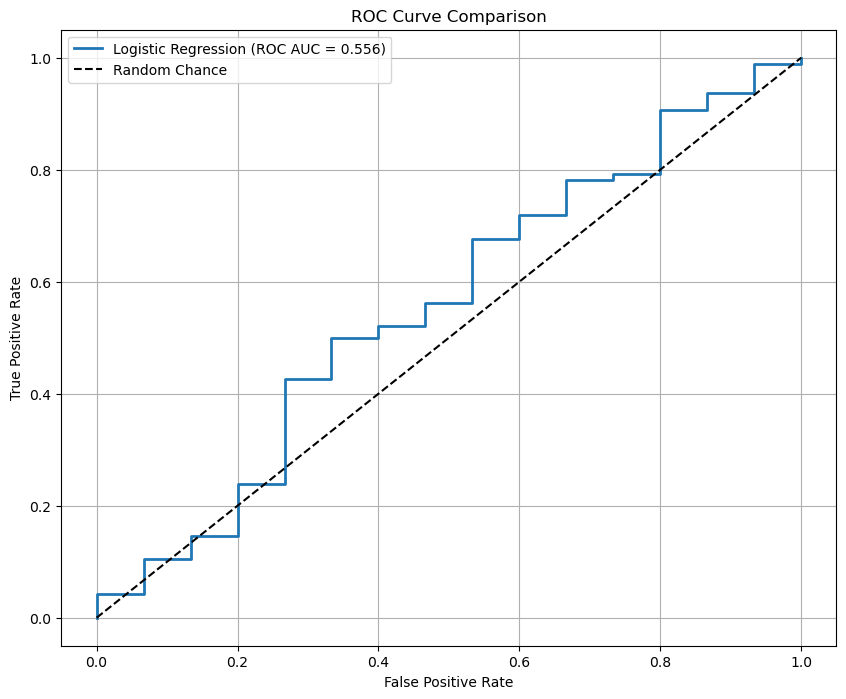

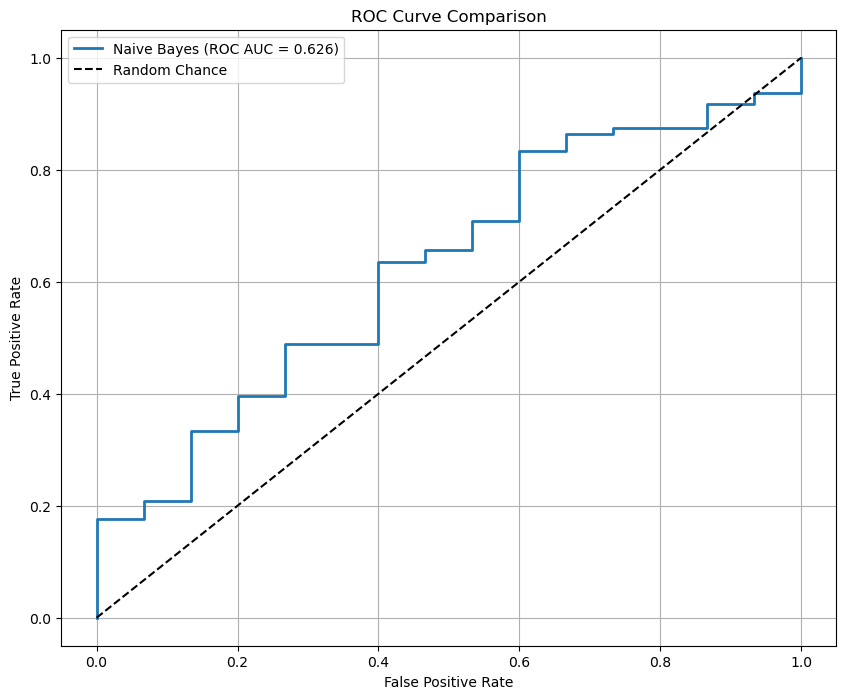

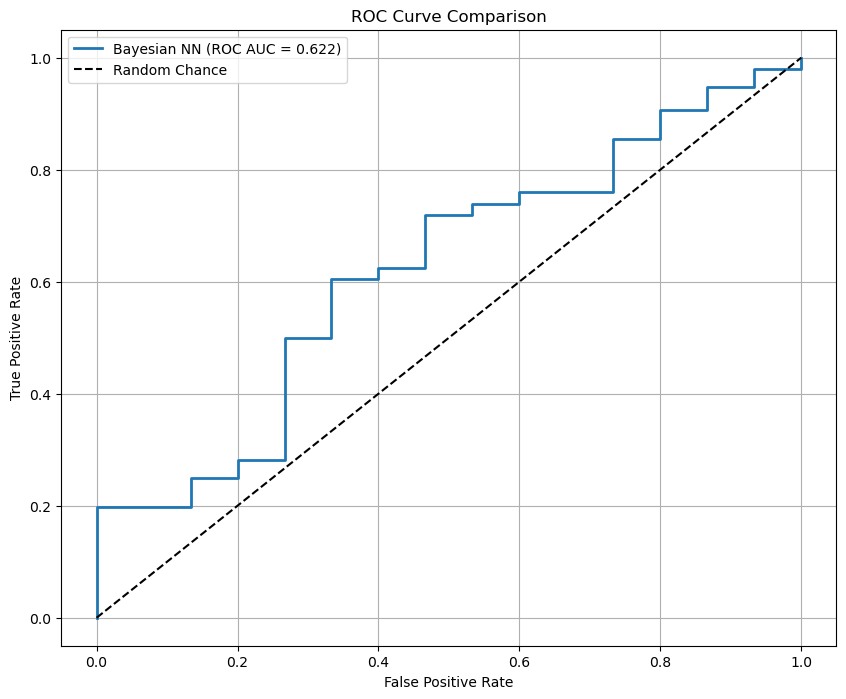

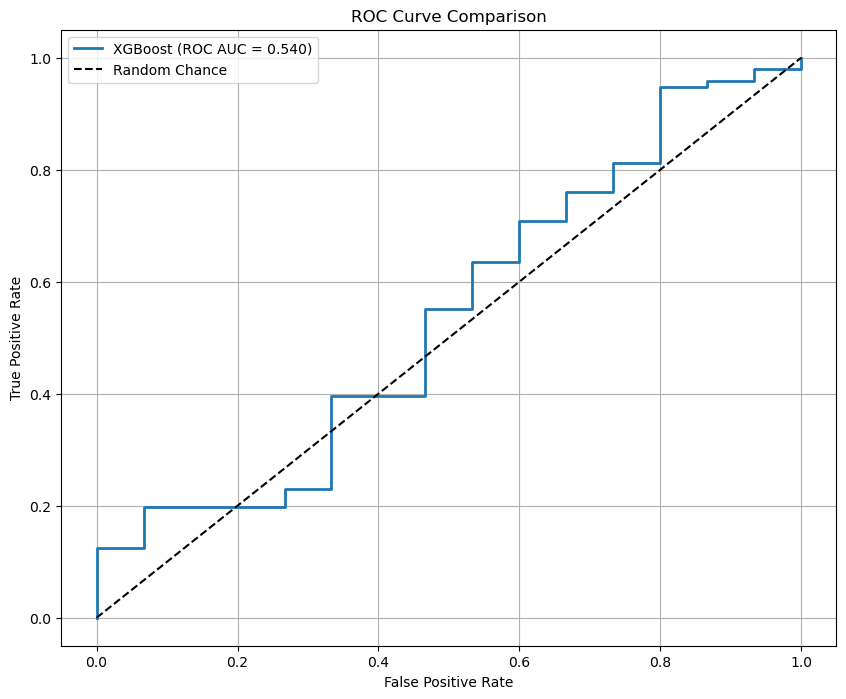

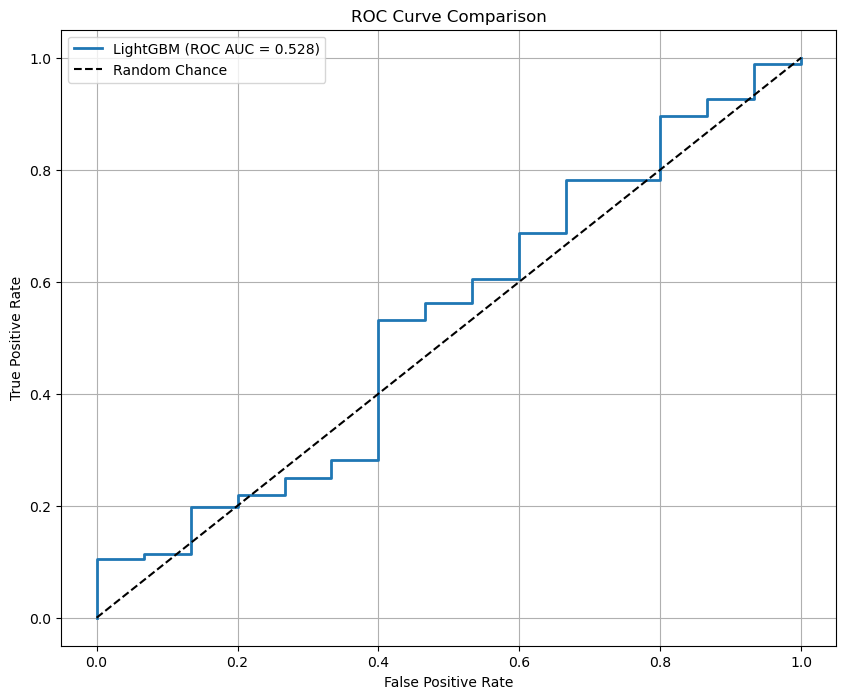

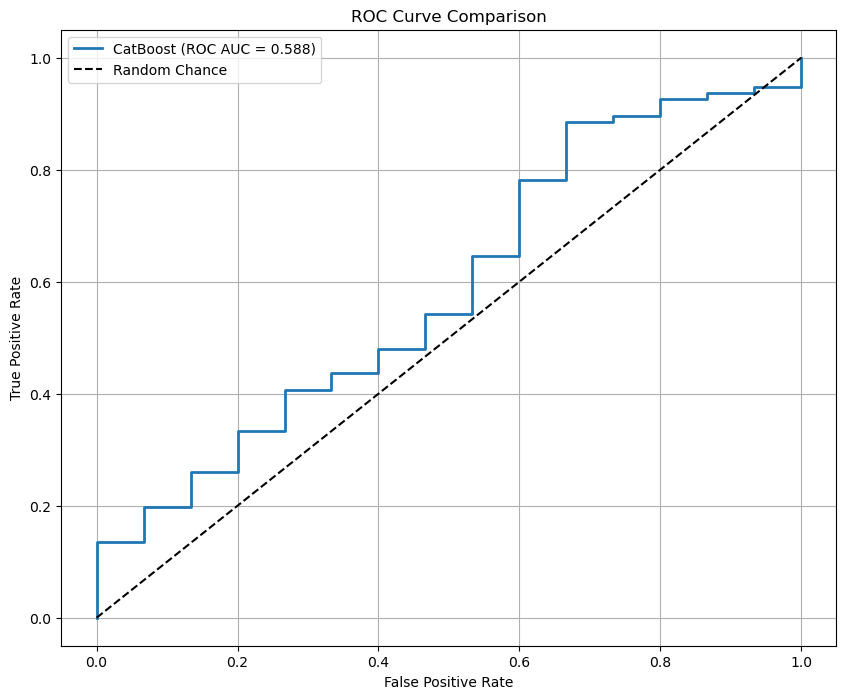

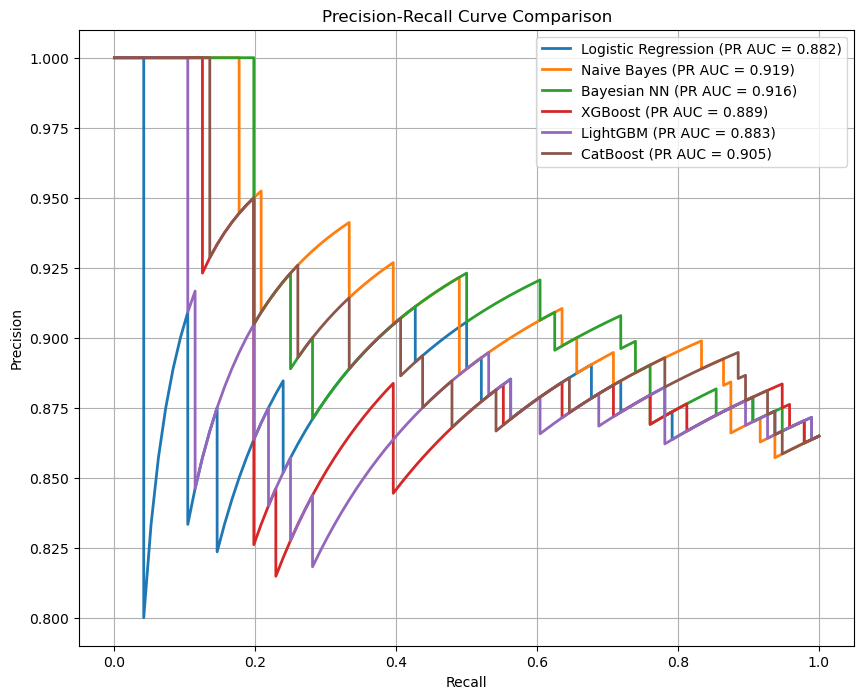

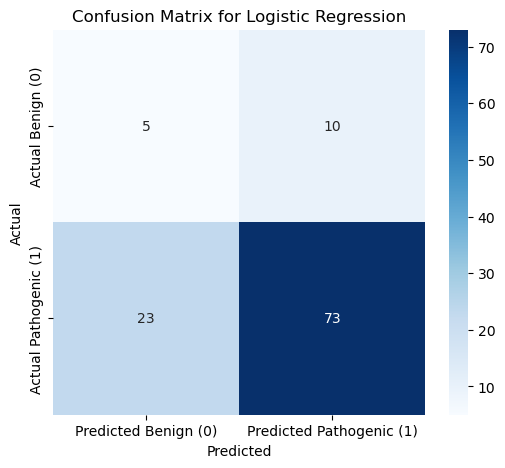

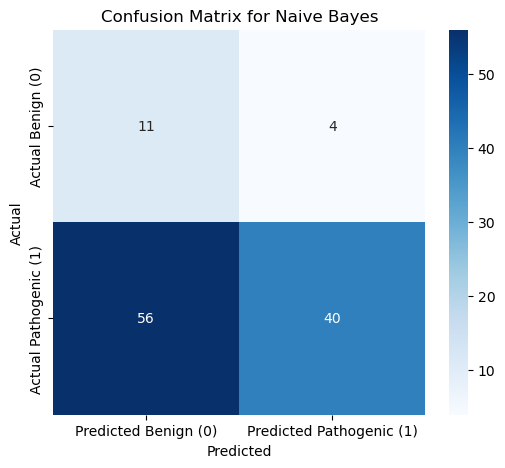

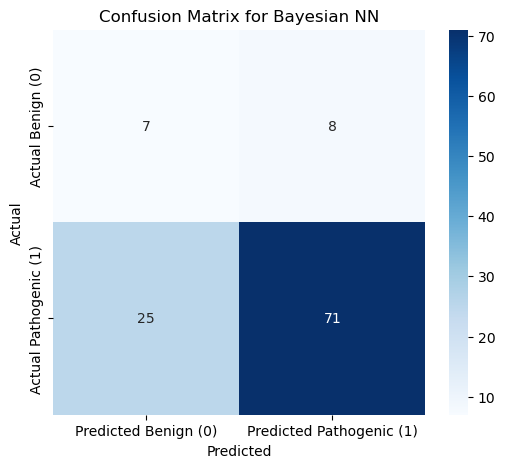

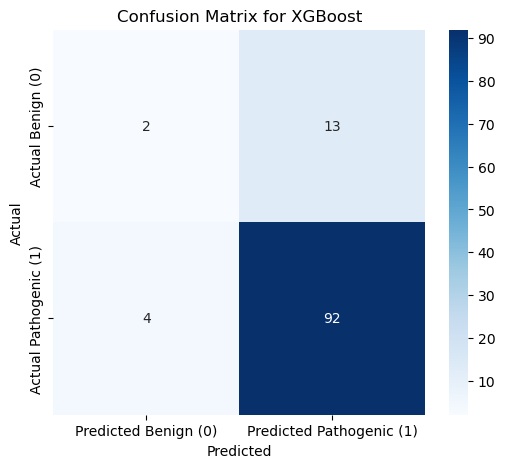

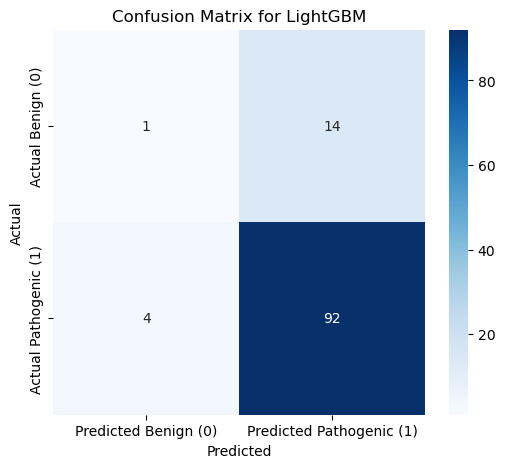

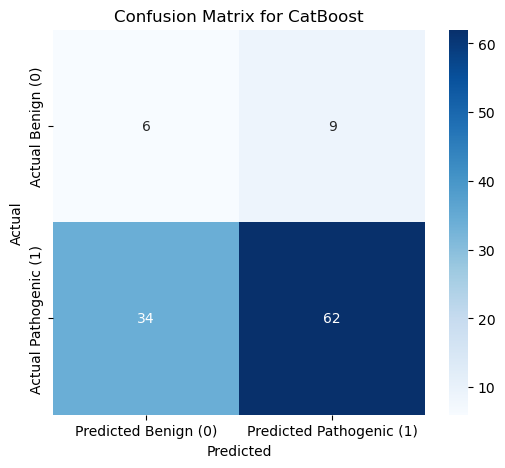

In [45]:
print("\n\n--- Performance Visualizations ---")

# Plot 1: ROC Curve Comparison
for name, data in all_model_predictions.items():
    fpr, tpr, _ = roc_curve(y_test, data['y_pred_prob'])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, lw=2, label=f"{name} (ROC AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate'), plt.title('ROC Curve Comparison')
    plt.legend(), plt.grid(), plt.show()

# Plot 2: Precision-Recall Curve Comparison
plot_precision_recall_curves(all_model_predictions, y_test)

# Plot 3: Confusion Matrices for each model
for name, data in all_model_predictions.items():
    plot_confusion_matrix_heatmap(y_test, data['y_pred'], name)

In [40]:
print("\n\n--- Optuna Study Insights ---")
for name, study in optuna_studies.items():
    print(f"\n--- Plots for {name} ---")
    if study.best_trial:
        plot_optimization_history(study).show()
        plot_param_importances(study).show()
        plot_slice(study).show()
    else:
        print("No completed trials to plot.")



--- Optuna Study Insights ---


NameError: name 'optuna_studies' is not defined



--- SHAP Explanations for Tree-Based Models ---

--- Analyzing model: Logistic Regression ---
Object is a direct model of type: <class 'sklearn.linear_model._logistic.LogisticRegression'>
SKIPPING: Model type is not compatible with SHAP TreeExplainer.

--- Analyzing model: Naive Bayes ---
Object is a direct model of type: <class 'sklearn.naive_bayes.GaussianNB'>
SKIPPING: Model type is not compatible with SHAP TreeExplainer.

--- Analyzing model: Bayesian NN ---
Object is a direct model of type: <class '__main__.BayesByBackpropClassifier'>
SKIPPING: Model type is not compatible with SHAP TreeExplainer.

--- Analyzing model: XGBoost ---
Object is a Pipeline. Extracted model of type: <class 'xgboost.sklearn.XGBClassifier'>
SUCCESS: Found a compatible model. Generating SHAP summary...


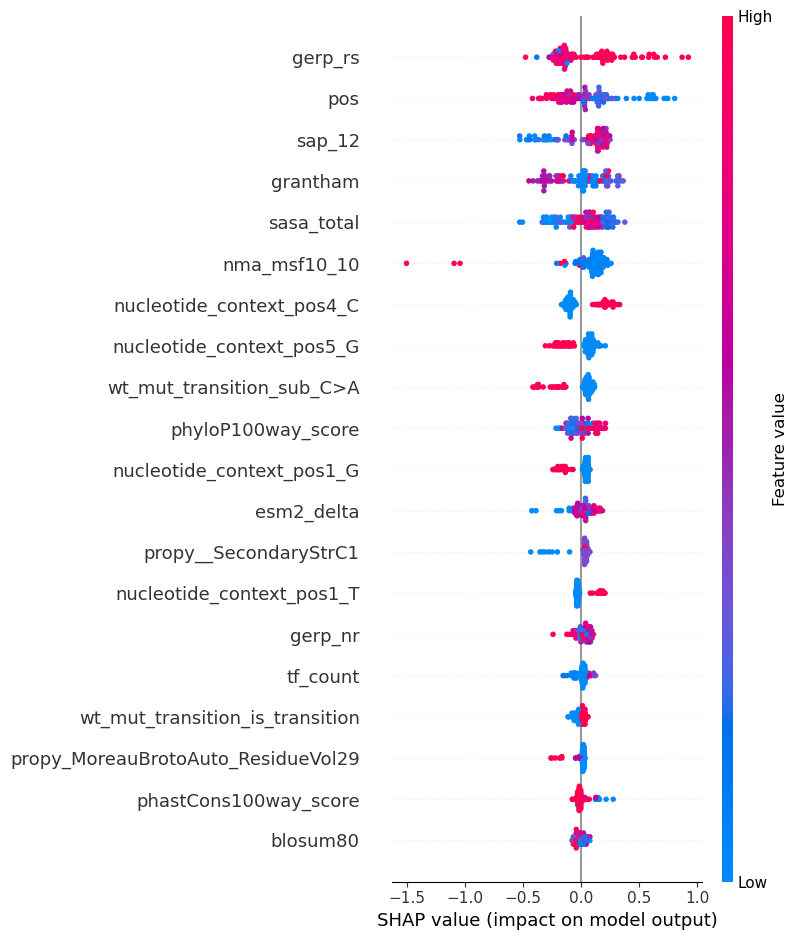


--- Analyzing model: LightGBM ---
Object is a Pipeline. Extracted model of type: <class 'lightgbm.sklearn.LGBMClassifier'>
SUCCESS: Found a compatible model. Generating SHAP summary...


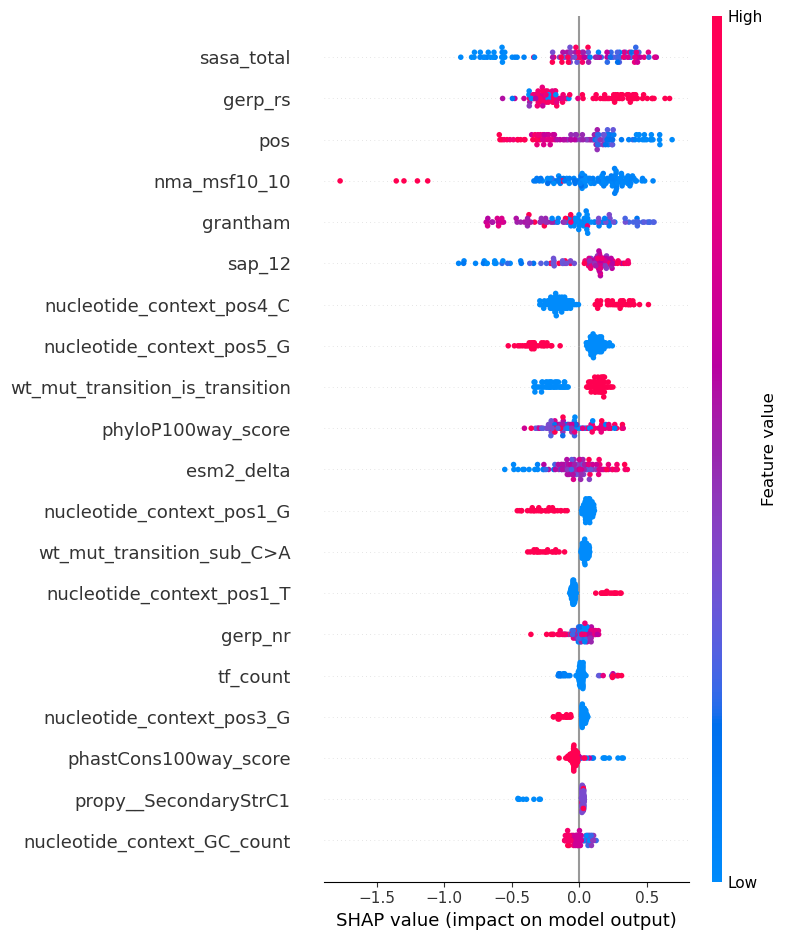


--- Analyzing model: CatBoost ---
Object is a Pipeline. Extracted model of type: <class 'catboost.core.CatBoostClassifier'>
SUCCESS: Found a compatible model. Generating SHAP summary...


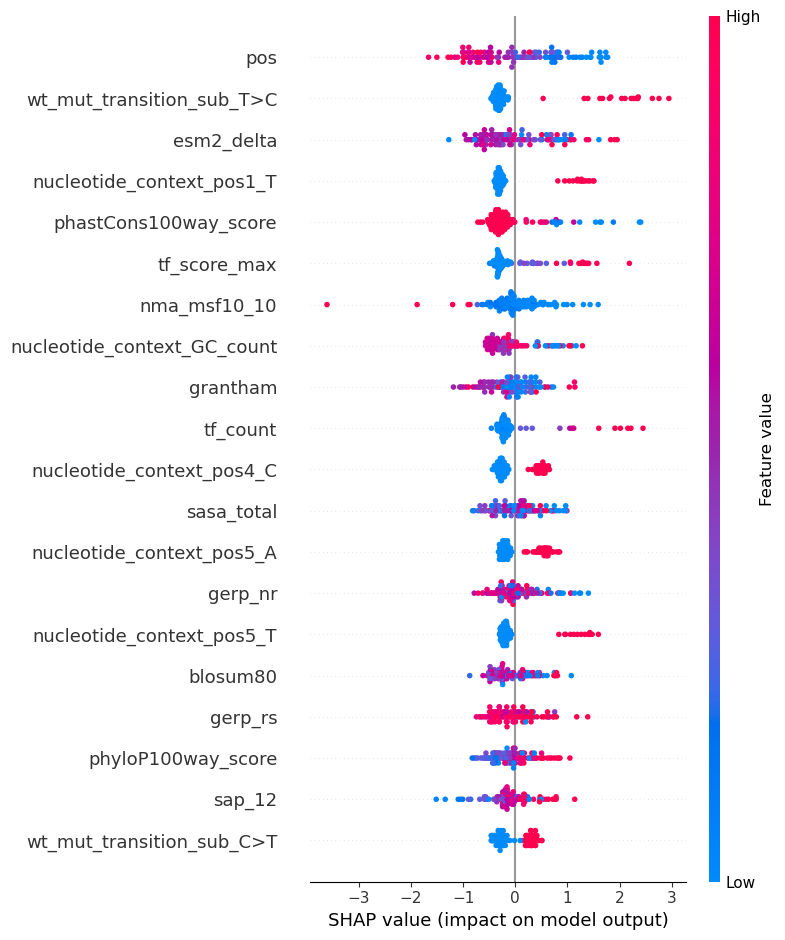

In [47]:
print("\n\n--- SHAP Explanations for Tree-Based Models ---")

# Iterate through the dictionary which contains a mix of models and pipelines
for name, fitted_object in fitted_models.items():

    print(f"\n--- Analyzing model: {name} ---")

    # This block determines if we have a pipeline or a direct model
    # and extracts the core classifier.
    if isinstance(fitted_object, Pipeline):
        # This will be the case for XGBoost, LightGBM, CatBoost
        model_to_explain = fitted_object.named_steps['classifier']
        print(f"Object is a Pipeline. Extracted model of type: {type(model_to_explain)}")

        # For pipelines, we must transform the RAW test data before explaining
        data_for_shap = fitted_object.named_steps['preprocessor'].transform(X_test_raw)
        
        # Also get the feature names from the preprocessor
        features_for_shap = fitted_object.named_steps['preprocessor'].get_feature_names_out()

    else:
        # This will be the case for Logistic Regression and Naive Bayes
        model_to_explain = fitted_object
        print(f"Object is a direct model of type: {type(model_to_explain)}")
        
        # For direct models, they were trained on PROCESSED data, so we use X_test
        data_for_shap = X_test
        features_for_shap = X_test.columns

    if isinstance(model_to_explain, (xgb.XGBClassifier, LGBMClassifier, CatBoostClassifier)):
        print(f"SUCCESS: Found a compatible model. Generating SHAP summary...")

        try:
            explainer = shap.TreeExplainer(model_to_explain)
            shap_values = explainer.shap_values(data_for_shap)

            # Create the summary plot
            shap.summary_plot(shap_values, data_for_shap, feature_names=features_for_shap)
            plt.show()

        except Exception as e:
            print(f"An error occurred during SHAP processing for {name}: {e}")

    else:
        # This correctly skips non-tree models
        print(f"SKIPPING: Model type is not compatible with SHAP TreeExplainer.")

In [ ]:
def _coerce_shap_to_array(shap_values):
    """
    Returns a (n_samples, n_features) ndarray for binary/multiclass SHAP.
    For binary classifiers, we use the class-1 attributions when SHAP returns a list.
    """
    if isinstance(shap_values, list):
        # common for tree models: [class0, class1, ...]
        # pick positive class (1) if available, else the last
        idx = 1 if len(shap_values) > 1 else -1
        return shap_values[idx]
    return shap_values

def shap_global_importance_df(shap_values, feature_names):
    """
    Build a DataFrame of global importance = mean(|SHAP|) per feature.
    """
    sv = _coerce_shap_to_array(shap_values)
    mean_abs = np.abs(sv).mean(axis=0)
    df = (pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs})
            .sort_values("mean_abs_shap", ascending=False)
            .reset_index(drop=True))
    return df

def plot_shap_global_bar(imp_df, top_n=20, title="SHAP Global Importance (mean |SHAP|)"):
    """
    Horizontal bar chart of top-k features by mean(|SHAP|).
    """
    top = imp_df.head(top_n).iloc[::-1]  # reverse for barh (top at the top)
    plt.figure(figsize=(10, 6))
    plt.barh(top["feature"], top["mean_abs_shap"])
    plt.xlabel("mean(|SHAP|)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_shap_dependences(shap_values, X_matrix, feature_names, features=None, max_plots=6, model_name=""):
    """
    Dependence plots for selected features. If `features` is None, uses the top-k by mean(|SHAP|).
    """
    sv = _coerce_shap_to_array(shap_values)
    if features is None:
        imp_df = shap_global_importance_df(sv, feature_names)
        features = imp_df["feature"].head(max_plots).tolist()

    for f in features[:max_plots]:
        plt.figure(figsize=(7, 5))
        shap.dependence_plot(
            f,
            sv,
            X_matrix,
            feature_names=feature_names,
            show=False
        )
        plt.title(f"SHAP dependence: {f} ({model_name})")
        plt.tight_layout()
        plt.show()



--- SHAP Explanations for Tree-Based Models ---

--- Analyzing model: Logistic Regression ---
Object is a direct model: <class 'sklearn.linear_model._logistic.LogisticRegression'>
SKIPPING: Model type is not compatible with SHAP TreeExplainer.

--- Analyzing model: Naive Bayes ---
Object is a direct model: <class 'sklearn.naive_bayes.GaussianNB'>
SKIPPING: Model type is not compatible with SHAP TreeExplainer.

--- Analyzing model: Bayesian NN ---
Object is a direct model: <class '__main__.BayesByBackpropClassifier'>
SKIPPING: Model type is not compatible with SHAP TreeExplainer.

--- Analyzing model: XGBoost ---
Object is a Pipeline. Extracted model: <class 'xgboost.sklearn.XGBClassifier'>
SUCCESS: Tree model detected. Computing SHAP values...


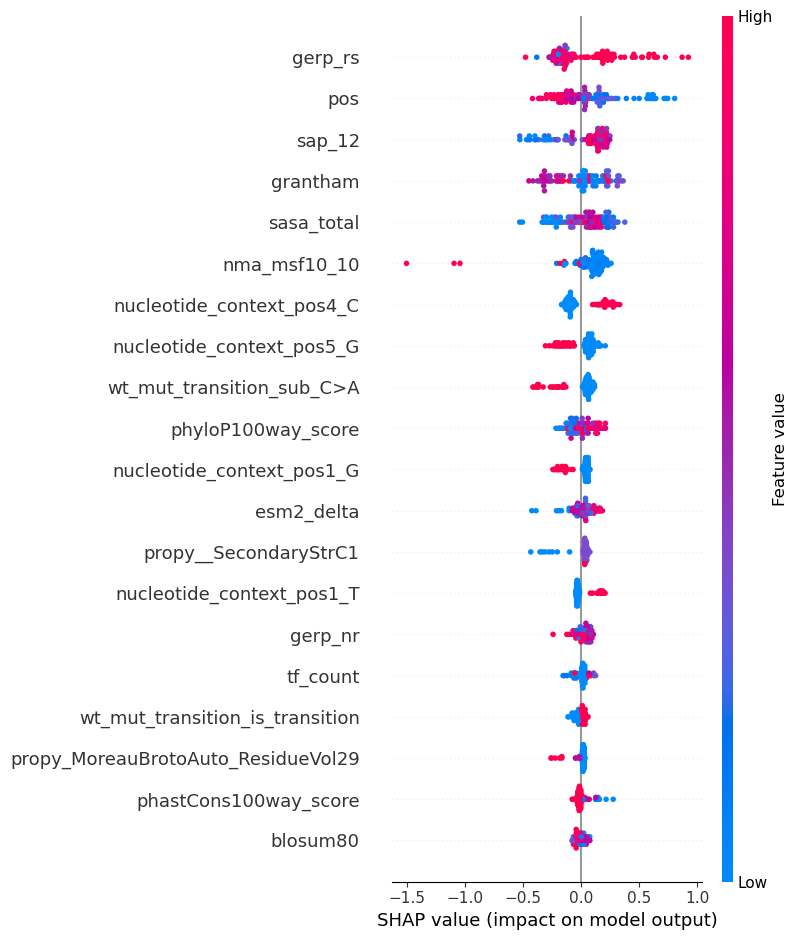

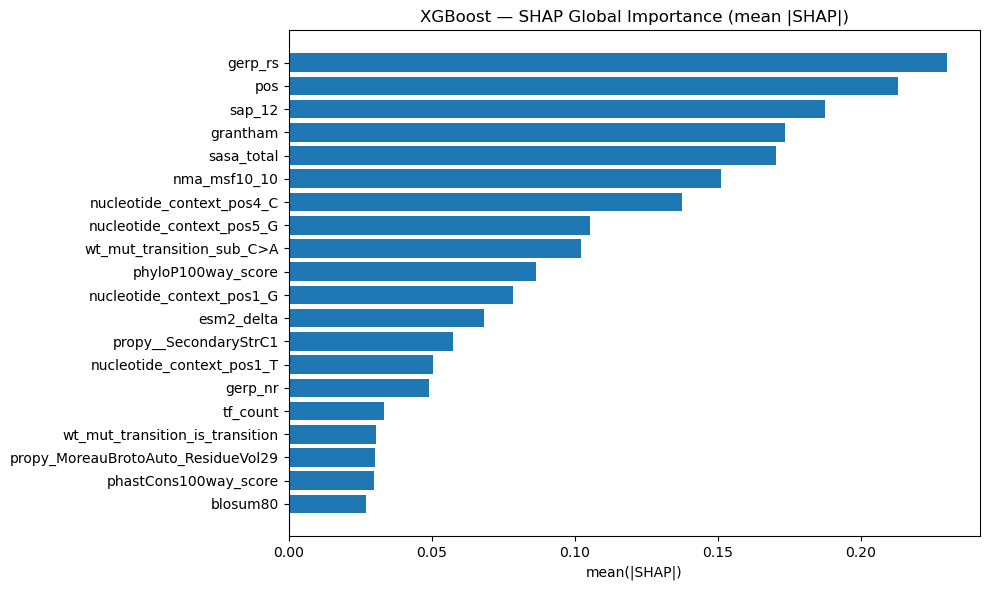

<Figure size 700x500 with 0 Axes>

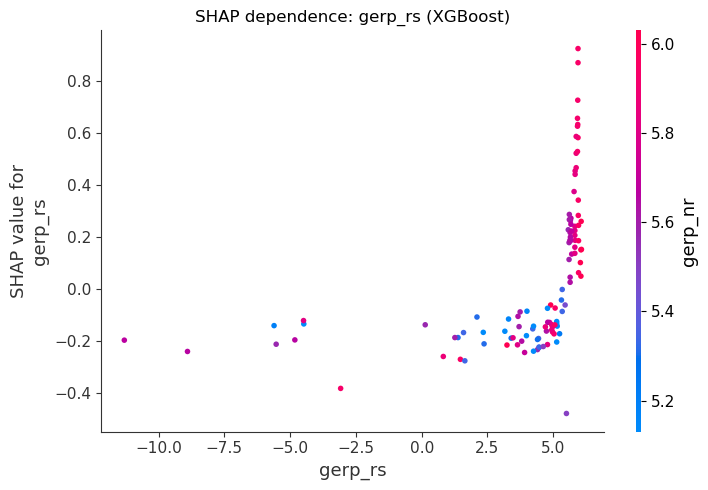

<Figure size 700x500 with 0 Axes>

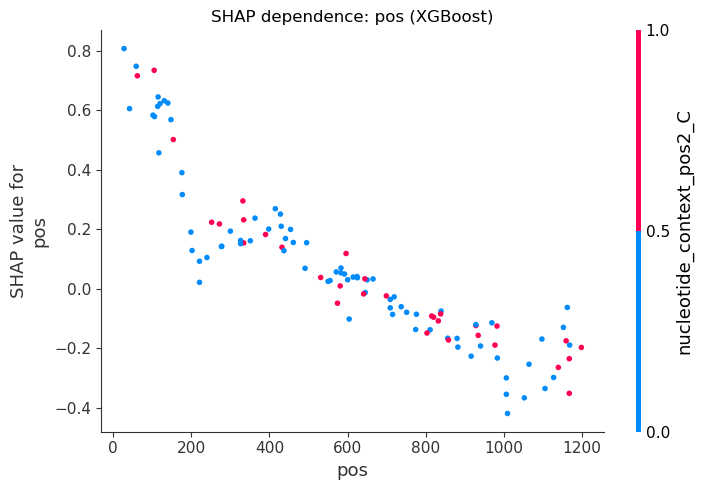

<Figure size 700x500 with 0 Axes>

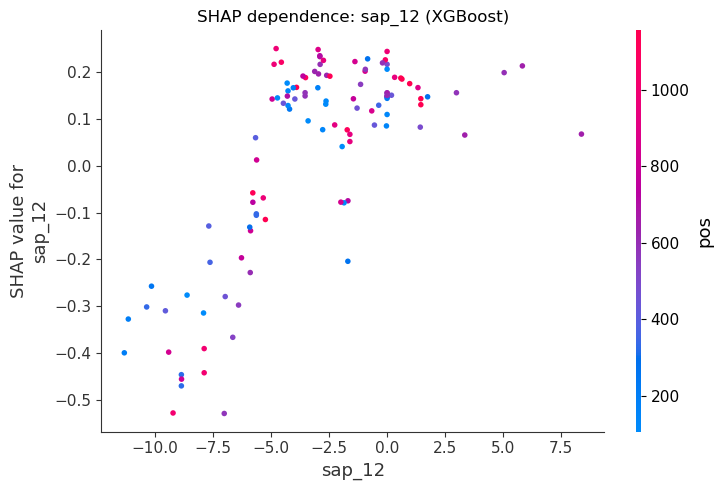

<Figure size 700x500 with 0 Axes>

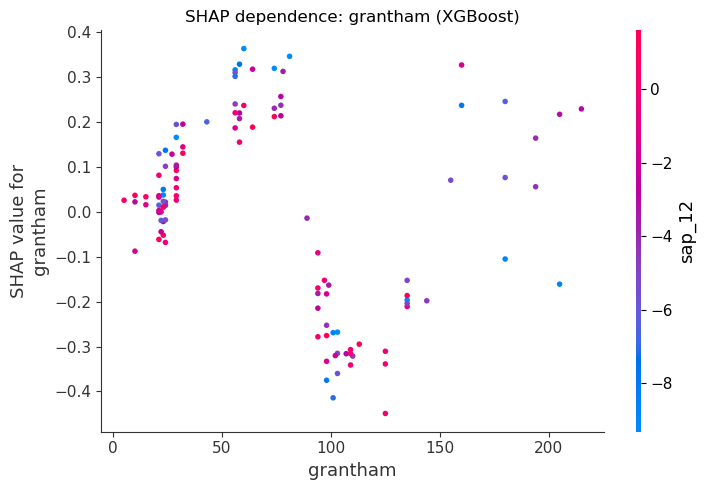

<Figure size 700x500 with 0 Axes>

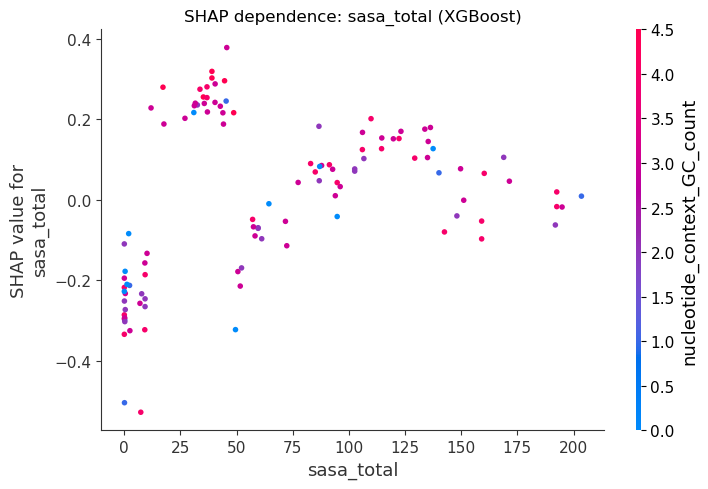

<Figure size 700x500 with 0 Axes>

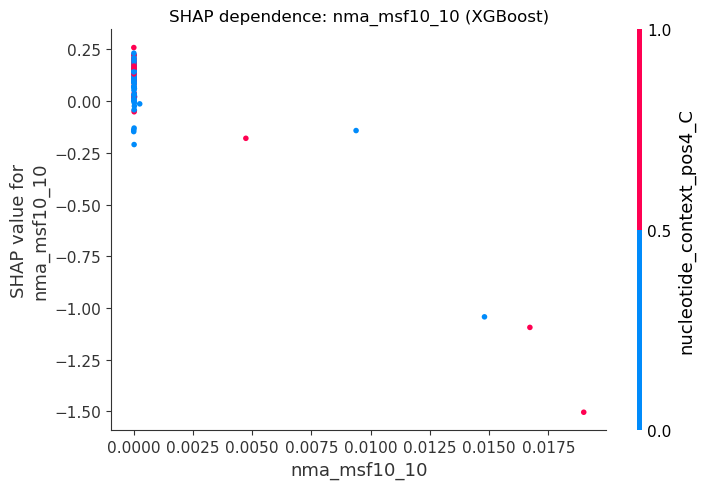


--- Analyzing model: LightGBM ---
Object is a Pipeline. Extracted model: <class 'lightgbm.sklearn.LGBMClassifier'>
SUCCESS: Tree model detected. Computing SHAP values...


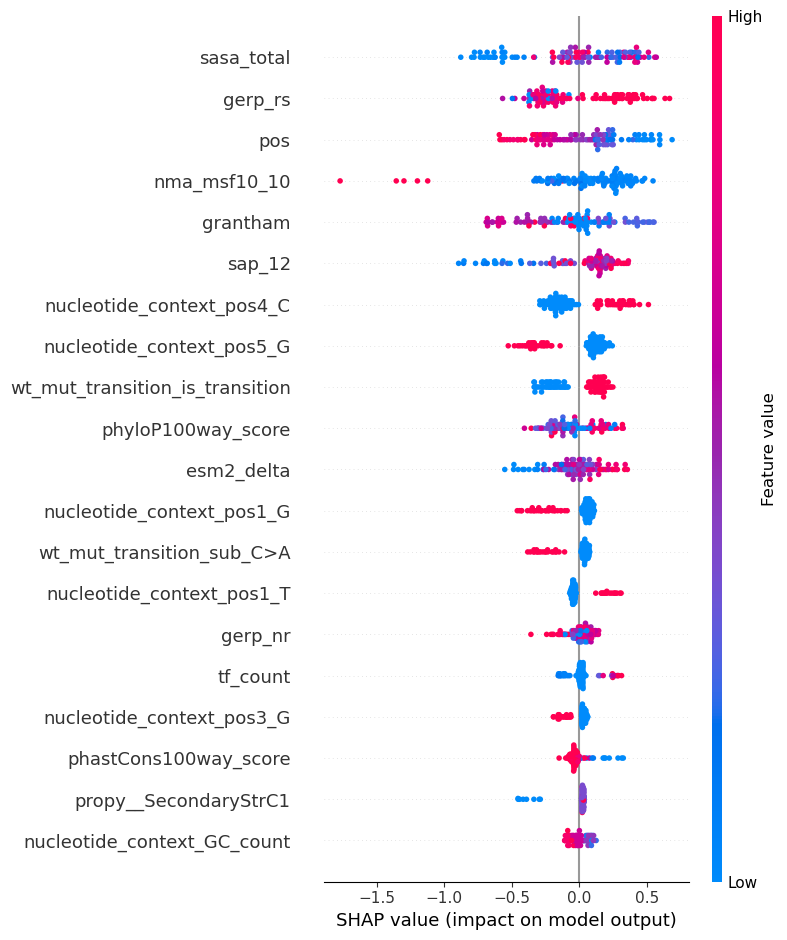

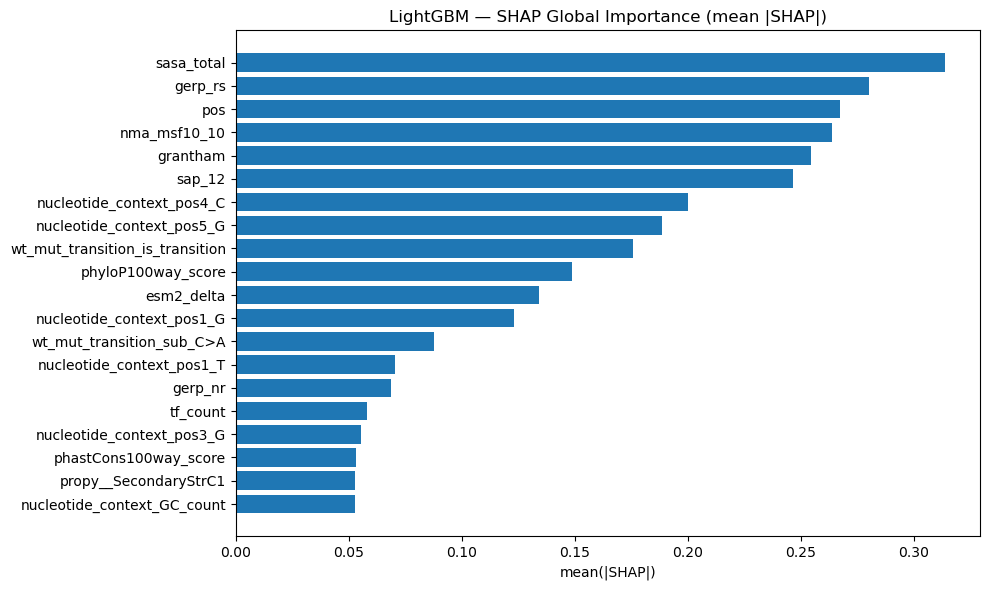

<Figure size 700x500 with 0 Axes>

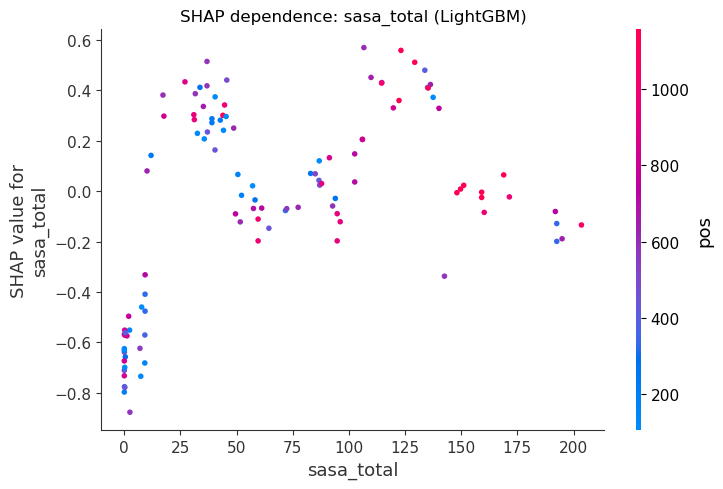

<Figure size 700x500 with 0 Axes>

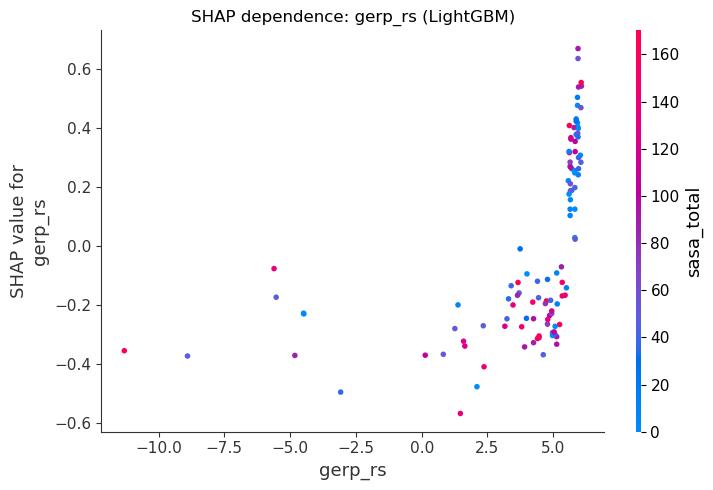

<Figure size 700x500 with 0 Axes>

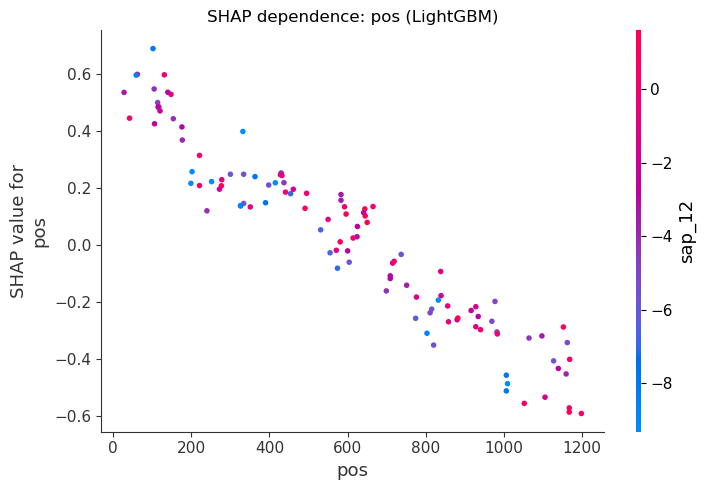

<Figure size 700x500 with 0 Axes>

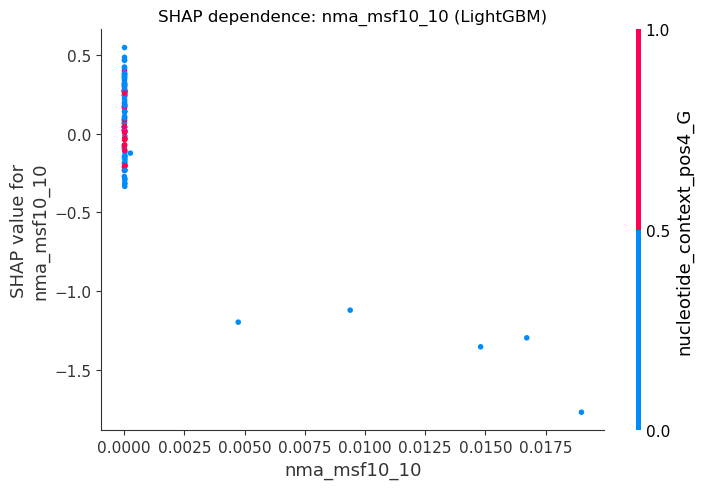

<Figure size 700x500 with 0 Axes>

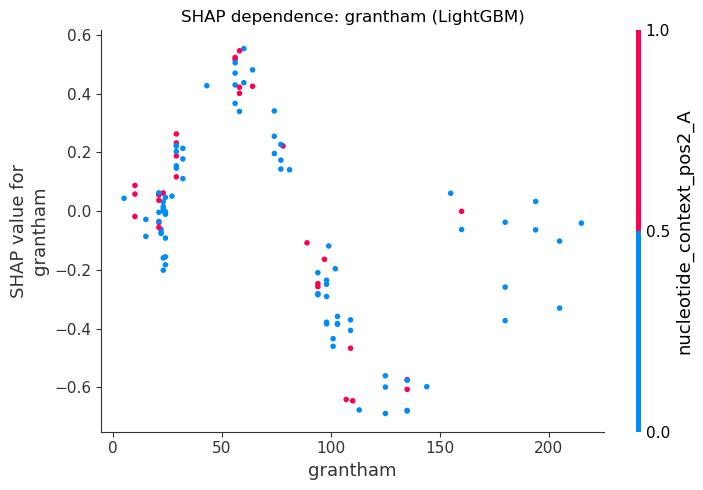

<Figure size 700x500 with 0 Axes>

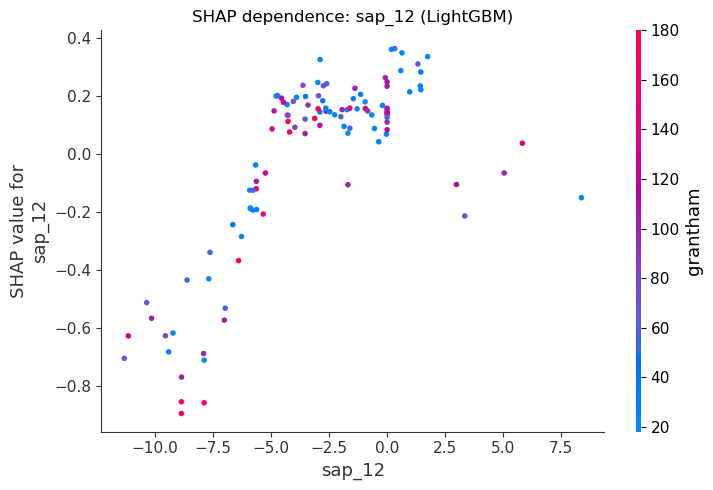


--- Analyzing model: CatBoost ---
Object is a Pipeline. Extracted model: <class 'catboost.core.CatBoostClassifier'>
SUCCESS: Tree model detected. Computing SHAP values...


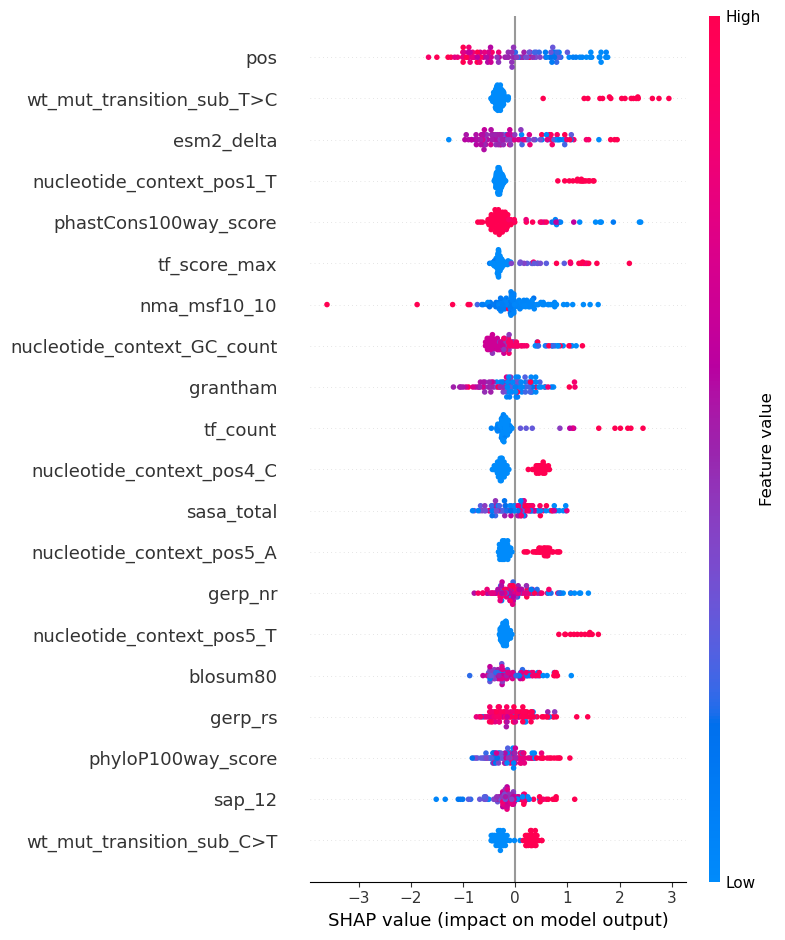

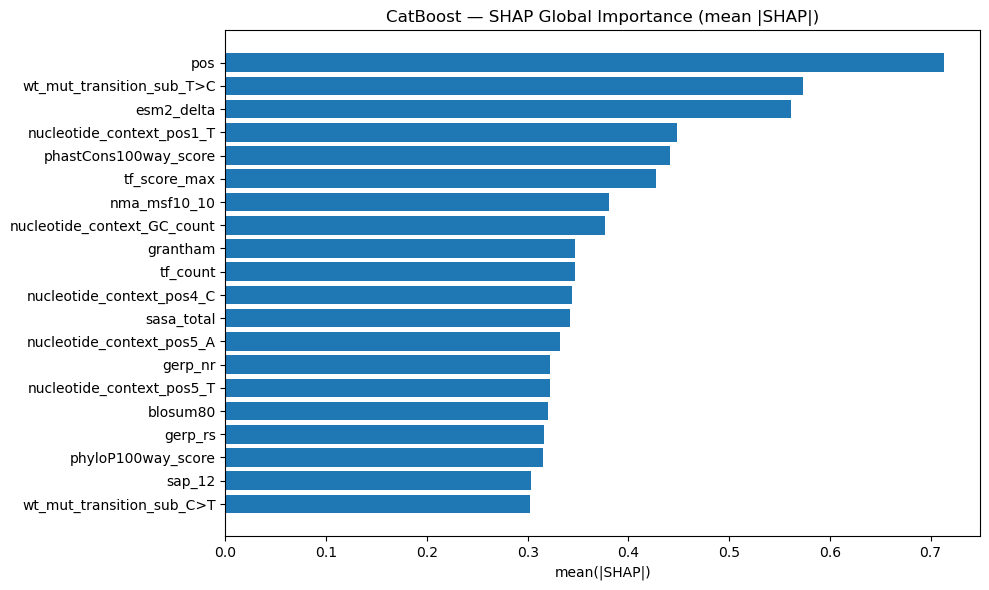

<Figure size 700x500 with 0 Axes>

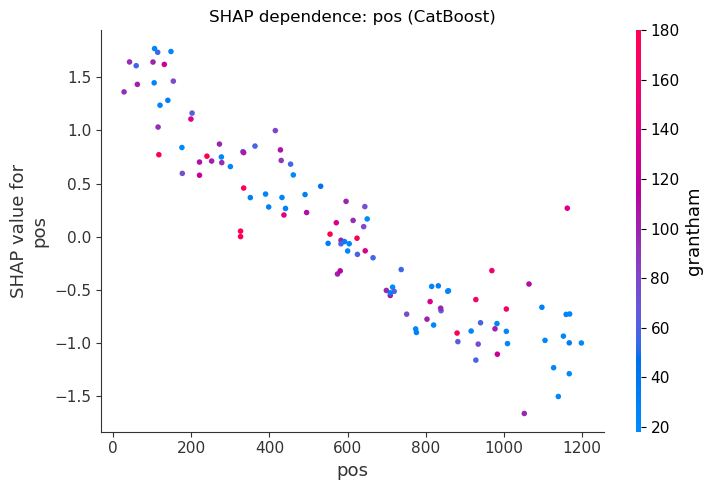

<Figure size 700x500 with 0 Axes>

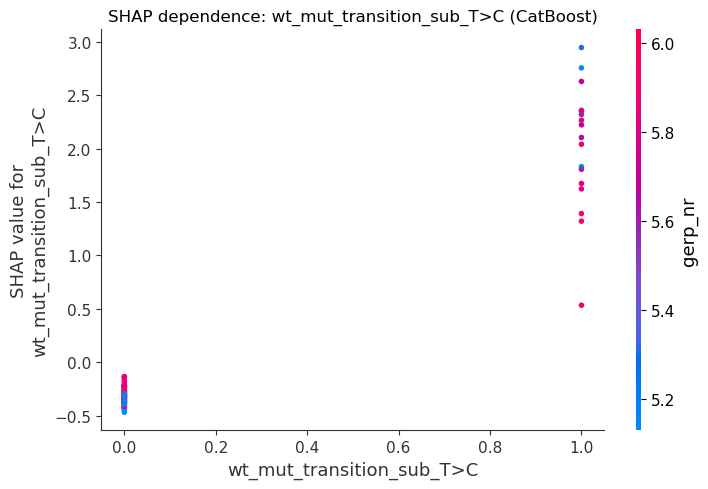

<Figure size 700x500 with 0 Axes>

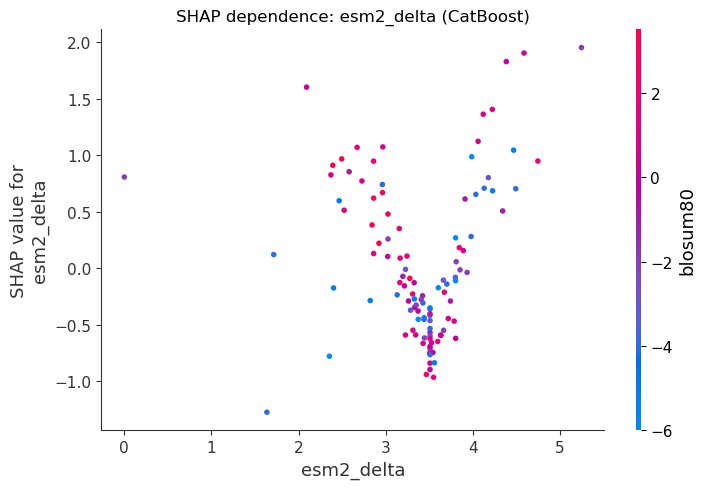

<Figure size 700x500 with 0 Axes>

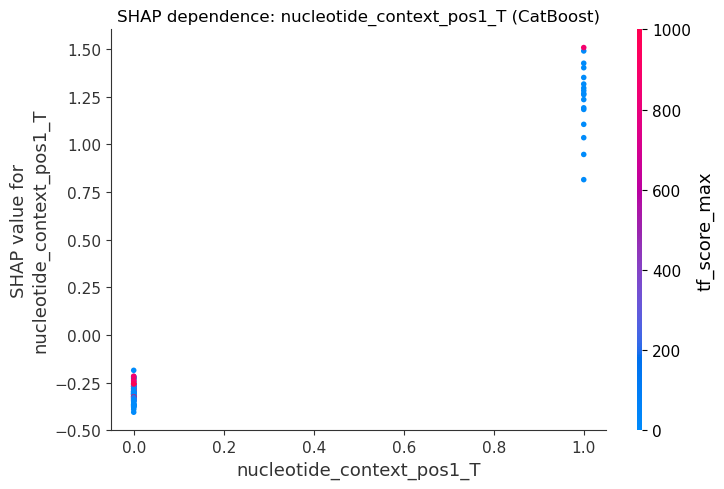

<Figure size 700x500 with 0 Axes>

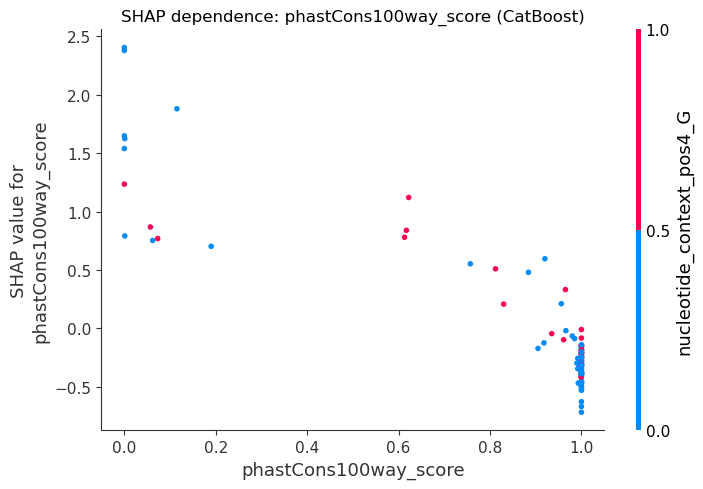

<Figure size 700x500 with 0 Axes>

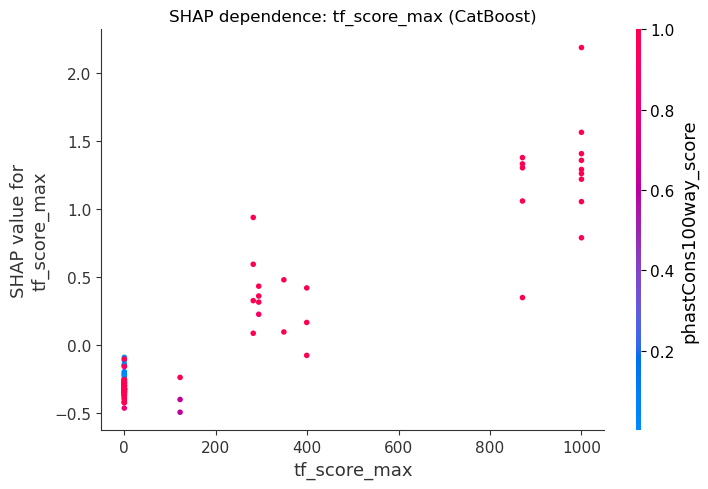

In [ ]:
print("\n\n--- SHAP Explanations for Tree-Based Models ---")
for name, fitted_object in fitted_models.items():
    print(f"\n--- Analyzing model: {name} ---")

    # Extract core classifier + the data/features used to train it
    if isinstance(fitted_object, Pipeline):
        model_to_explain = fitted_object.named_steps['classifier']
        print(f"Object is a Pipeline. Extracted model: {type(model_to_explain)}")
        data_for_shap = fitted_object.named_steps['preprocessor'].transform(X_test_raw)
        features_for_shap = fitted_object.named_steps['preprocessor'].get_feature_names_out()
    else:
        model_to_explain = fitted_object
        print(f"Object is a direct model: {type(model_to_explain)}")
        data_for_shap = X_test
        features_for_shap = X_test.columns

    if isinstance(model_to_explain, (xgb.XGBClassifier, LGBMClassifier, CatBoostClassifier)):
        print("SUCCESS: Tree model detected. Computing SHAP values...")
        try:
            explainer = shap.TreeExplainer(model_to_explain)
            shap_values = explainer.shap_values(data_for_shap)

            # (a) Beeswarm (global overview; signed distributions)
            shap.summary_plot(
                _coerce_shap_to_array(shap_values),
                data_for_shap,
                feature_names=features_for_shap,
                show=True
            )

            # (b) Global bar of mean(|SHAP|)
            imp_df = shap_global_importance_df(shap_values, features_for_shap)
            plot_shap_global_bar(
                imp_df,
                top_n=20,
                title=f"{name} — SHAP Global Importance (mean |SHAP|)"
            )

            # (c) Dependence plots for top-k features
            plot_shap_dependences(
                shap_values,
                data_for_shap,
                feature_names=features_for_shap,
                features=None,          # or pass a custom list of feature names
                max_plots=6,
                model_name=name
            )

        except Exception as e:
            print(f"An error occurred during SHAP processing for {name}: {e}")
    else:
        print("SKIPPING: Model type is not compatible with SHAP TreeExplainer.")


In [ ]:
def bnn_predict_proba_samples(model, X, n_samples=50):
    """
    Returns array of shape (n_samples, n_obs) with MC probability samples for class 1.
    Falls back to repeating deterministic probs for non-BNN models.
    """
    if hasattr(model, "_net"):  # our BayesByBackpropClassifier
        import torch
        dev = torch.device(model.device_ if hasattr(model, "device_") else ('cuda' if torch.cuda.is_available() else 'cpu'))
        model._net.eval()
        Xt = torch.from_numpy(np.asarray(X, np.float32)).to(dev)
        outs = []
        with torch.no_grad():
            for _ in range(n_samples):
                logits, _, _ = model._net(Xt, sample=True)
                outs.append(torch.sigmoid(logits).cpu().numpy())
        return np.vstack(outs)
    else:
        p = model.predict_proba(X)[:, 1]
        return np.tile(p, (n_samples, 1))

def _binary_entropy(p, eps=1e-12):
    p = np.clip(p, eps, 1 - eps)
    return -(p*np.log(p) + (1-p)*np.log(1-p))

def summarize_bnn_uncertainty(model, X, y_true, n_samples=50):
    """Compute per-sample uncertainty summaries."""
    samps = bnn_predict_proba_samples(model, X, n_samples=n_samples)   # (S, N)
    p_mean = samps.mean(axis=0)
    p_std  = samps.std(axis=0)
    H_pred = _binary_entropy(p_mean)                 # predictive entropy
    H_exp  = _binary_entropy(samps).mean(axis=0)     # expected data entropy
    mi     = H_pred - H_exp                          # Epistemic uncertainty

    y_true = np.asarray(y_true).astype(int)
    y_hat  = (p_mean >= 0.5).astype(int)
    correct = (y_hat == y_true).astype(int)
    conf = np.maximum(p_mean, 1 - p_mean)

    return {
        "p_mean": p_mean, "p_std": p_std,
        "entropy": H_pred, "mutual_info": mi,
        "confidence": conf, "y_true": y_true, "y_hat": y_hat, "correct": correct,
        "samples": samps
    }


In [ ]:
def plot_reliability(y_true, p, n_bins=15, title="Reliability diagram"):
    """Calibration plot + ECE & Brier."""
    y_true = np.asarray(y_true).astype(int)
    p = np.asarray(p)
    bins = np.linspace(0, 1, n_bins+1)
    idx = np.digitize(p, bins) - 1
    frac_pos, mean_pred, counts = [], [], []
    for b in range(n_bins):
        m = idx == b
        if m.any():
            frac_pos.append(y_true[m].mean())
            mean_pred.append(p[m].mean())
            counts.append(m.sum())
        else:
            frac_pos.append(np.nan); mean_pred.append((bins[b]+bins[b+1])/2); counts.append(0)
    frac_pos = np.array(frac_pos, float)
    mean_pred = np.array(mean_pred, float)

    # ECE
    weights = np.array(counts)/max(1, sum(counts))
    ece = np.nansum(weights * np.abs(frac_pos - mean_pred))
    # Brier
    brier = np.mean((p - y_true)**2)

    plt.figure(figsize=(6,6))
    plt.plot([0,1],[0,1],'--', linewidth=1)
    plt.plot(mean_pred, frac_pos, marker='o')
    plt.xlabel('Predicted probability'); plt.ylabel('Empirical frequency')
    plt.title(f"{title}\nECE={ece:.3f}  Brier={brier:.3f}")
    plt.grid(True); plt.show()

def plot_mcc_vs_threshold(y_true, p, title="MCC vs threshold"):
    from sklearn.metrics import matthews_corrcoef
    thr = np.linspace(0,1,401)
    mcc = []
    y_true = np.asarray(y_true).astype(int)
    for t in thr:
        y_hat = (p >= t).astype(int)
        mcc.append(matthews_corrcoef(y_true, y_hat))
    plt.figure(figsize=(7,5))
    plt.plot(thr, mcc)
    plt.xlabel("Threshold"); plt.ylabel("MCC")
    i = int(np.nanargmax(mcc)); plt.axvline(thr[i], linestyle='--')
    plt.title(f"{title} (best {mcc[i]:.3f} @ {thr[i]:.3f})")
    plt.grid(True); plt.show()

def plot_risk_coverage(y_true, p, uncertainty, title="Risk-coverage (selective prediction)"):
    """
    Sort by uncertainty ascending; accept top-k (lowest uncertainty); plot error vs coverage.
    'uncertainty' can be std or mutual_info (higher=worse).
    """
    y_true = np.asarray(y_true).astype(int)
    p = np.asarray(p)
    # risk = 1 - accuracy
    order = np.argsort(uncertainty)          # lowest uncertainty first
    y_sorted = y_true[order]; p_sorted = p[order]
    yhat_sorted = (p_sorted >= 0.5).astype(int)
    correct = (yhat_sorted == y_sorted).astype(int)
    cum_acc = np.cumsum(correct) / (np.arange(len(correct))+1)
    coverage = (np.arange(len(correct))+1) / len(correct)
    risk = 1 - cum_acc
    plt.figure(figsize=(7,5))
    plt.plot(coverage, risk)
    plt.xlabel("Coverage"); plt.ylabel("Risk (1 - accuracy)")
    plt.title(title); plt.grid(True); plt.show()

def plot_mean_vs_uncertainty(p_mean, u, correct, title="Mean prob vs uncertainty"):
    plt.figure(figsize=(7,5))
    plt.scatter(p_mean, u, s=12, alpha=0.6, label=None)
    plt.xlabel("Predictive mean p(y=1|x)"); plt.ylabel("Uncertainty (e.g., std or MI)")
    plt.title(title)
    plt.grid(True); plt.show()

def plot_uncert_hist(u, correct, title="Uncertainty histogram"):
    u = np.asarray(u); correct = np.asarray(correct).astype(int)
    plt.figure(figsize=(7,5))
    plt.hist(u[correct==1], bins=30, alpha=0.6, label="Correct")
    plt.hist(u[correct==0], bins=30, alpha=0.6, label="Wrong")
    plt.xlabel("Uncertainty"); plt.ylabel("Count"); plt.title(title)
    plt.legend(); plt.grid(True); plt.show()

def plot_cm_with_uncert(y_true, y_hat, u, title="Confusion matrix with mean uncertainty"):
    """
    2x2 heatmap where each cell shows count and mean uncertainty.
    """
    from sklearn.metrics import confusion_matrix
    import numpy as np
    cm = confusion_matrix(y_true, y_hat, labels=[0,1])
    means = np.full((2,2), np.nan)
    for a in [0,1]:
        for p in [0,1]:
            mask = (y_true==a) & (y_hat==p)
            if mask.any():
                means[a,p] = np.mean(u[mask])
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['Pred 0','Pred 1']); ax.set_yticklabels(['True 0','True 1'])
    ax.set_title(title)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f"{cm[i,j]}\nμu={means[i,j]:.3f}" if not np.isnan(means[i,j]) else f"{cm[i,j]}\nμu=–",
                    ha="center", va="center")
    fig.colorbar(im, ax=ax)
    plt.tight_layout(); plt.show()

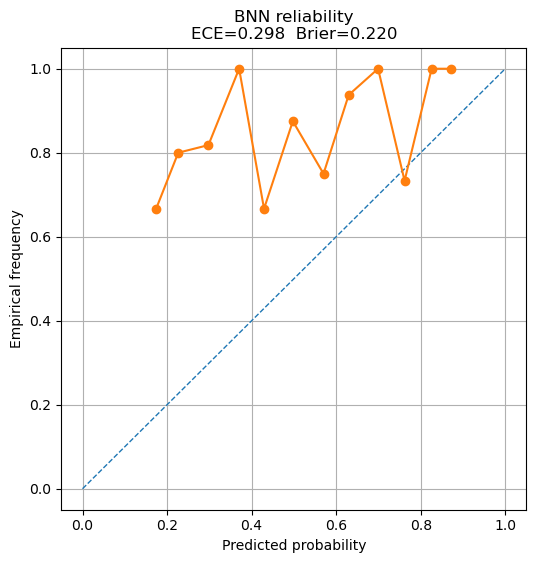

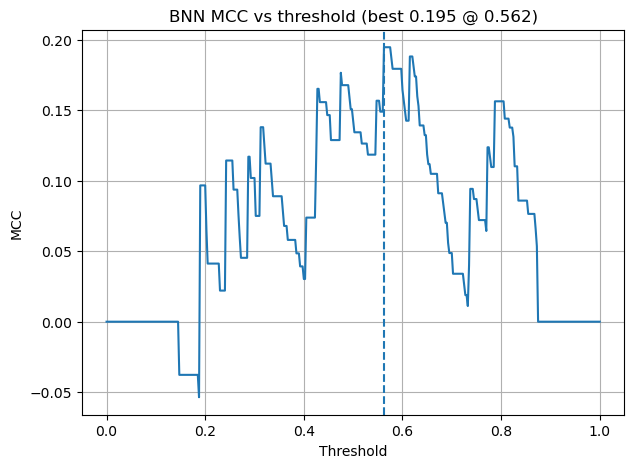

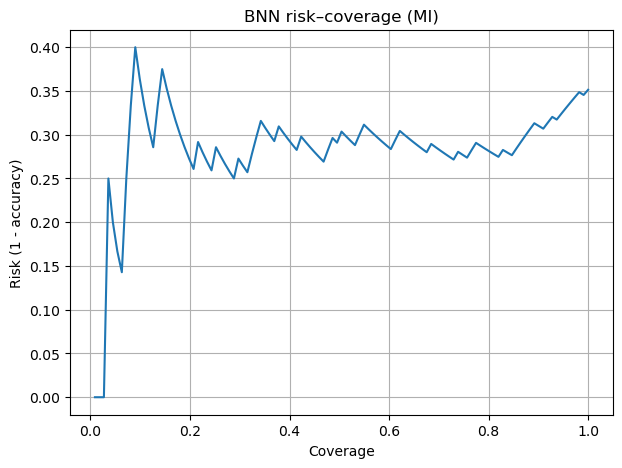

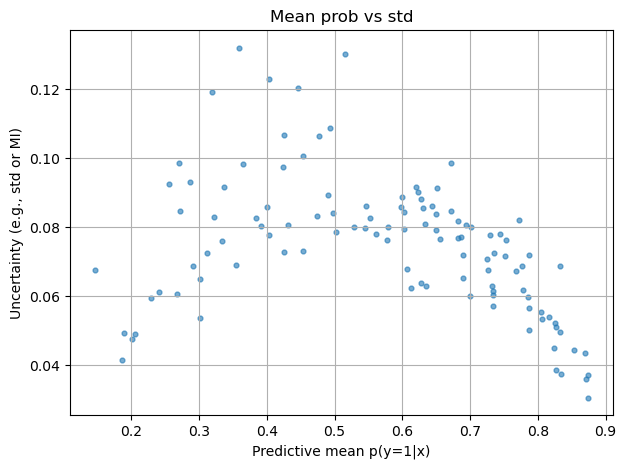

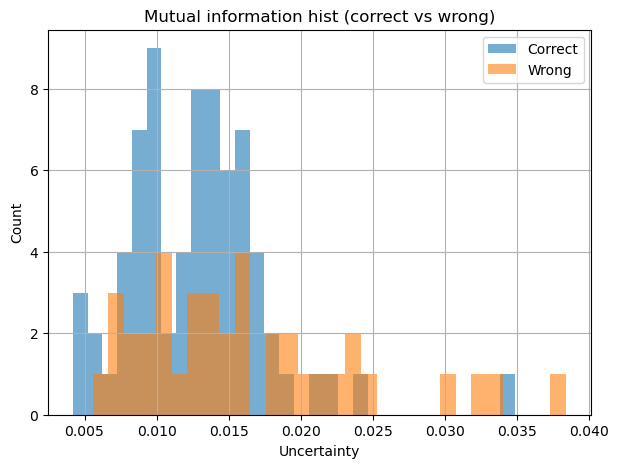

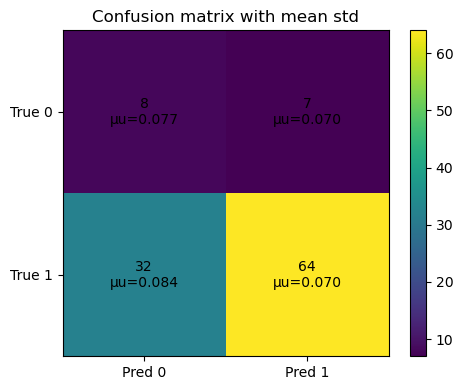

In [52]:
bnn = fitted_models['Bayesian NN']         
summ = summarize_bnn_uncertainty(bnn, X_test, y_test, n_samples=100)

# Core diagnostics
plot_reliability(summ["y_true"], summ["p_mean"], n_bins=15, title="BNN reliability")
plot_mcc_vs_threshold(summ["y_true"], summ["p_mean"], title="BNN MCC vs threshold")

# Uncertainty-driven views
plot_risk_coverage(summ["y_true"], summ["p_mean"], summ["mutual_info"], title="BNN risk–coverage (MI)")
plot_mean_vs_uncertainty(summ["p_mean"], summ["p_std"], summ["correct"], title="Mean prob vs std")
plot_uncert_hist(summ["mutual_info"], summ["correct"], title="Mutual information hist (correct vs wrong)")
plot_cm_with_uncert(summ["y_true"], summ["y_hat"], summ["p_std"], title="Confusion matrix with mean std")

In [ ]:
def bnn_single_point_report(model, x_row, *, n_samples=200, threshold=0.5, show_plot=True):
    """
    x_row: shape (1, n_features) - e.g. X_test.iloc[[i]]
    Returns dict with p_samples, p_mean, p_std, entropy, expected_entropy, mutual_info, conf, y_hat.
    If show_plot=True, draws a histogram of the MC predictive distribution.
    """
    # ensure 2D float32
    if hasattr(x_row, "values"):
        x_np = x_row.values.astype(np.float32)
    else:
        x_np = np.asarray(x_row, dtype=np.float32)
    if x_np.ndim == 1:
        x_np = x_np[None, :]  # (1, d)

    # MC samples from our BayesByBackpropClassifier
    if not hasattr(model, "_net"):
        # fall back for non-BNN models (repeat deterministic prob)
        p = model.predict_proba(x_np)[:, 1]
        p_samples = np.repeat(p, n_samples)
    else:
        dev = torch.device(model.device_ if hasattr(model, "device_") else ('cuda' if torch.cuda.is_available() else 'cpu'))
        model._net.eval()
        Xt = torch.from_numpy(x_np).to(dev)
        outs = []
        with torch.no_grad():
            for _ in range(n_samples):
                logits, _, _ = model._net(Xt, sample=True)
                outs.append(torch.sigmoid(logits).cpu().numpy()[0])
        p_samples = np.array(outs)  # (n_samples,)

    # summaries
    eps = 1e-12
    p_mean = float(p_samples.mean())
    p_std  = float(p_samples.std())
    # predictive entropy H[p(y|x)]
    H_pred = float(-(p_mean*np.log(p_mean+eps) + (1-p_mean)*np.log(1-p_mean+eps)))
    # expected entropy E_q[H[p(y|x,w)]]
    H_exp  = float(np.mean(-(p_samples*np.log(p_samples+eps) + (1-p_samples)*np.log(1-p_samples+eps))))
    # BALD mutual information (epistemic)
    MI = float(H_pred - H_exp)
    # confidence = max(p, 1-p)
    conf = float(max(p_mean, 1-p_mean))
    y_hat = int(p_mean >= threshold)

    # quick visualization
    if show_plot:
        plt.figure(figsize=(6,4))
        plt.hist(p_samples, bins=25, alpha=0.85, density=True)
        plt.axvline(p_mean, linestyle='--', linewidth=2, label=f"mean={p_mean:.3f}")
        if threshold is not None:
            plt.axvline(threshold, linestyle=':', linewidth=2, label=f"thr={threshold:.2f}")
        lo, hi = np.percentile(p_samples, [2.5, 97.5])
        plt.axvspan(lo, hi, alpha=0.15, label=f"95% CI [{lo:.3f}, {hi:.3f}]")
        plt.xlabel("p(y=1 | x, w)"); plt.ylabel("density"); plt.title("BNN predictive distribution (single x)")
        plt.legend(); plt.tight_layout(); plt.show()

    return {
        "p_samples": p_samples,
        "p_mean": p_mean,
        "p_std": p_std,
        "entropy": H_pred,
        "expected_entropy": H_exp,
        "mutual_info": MI,         # epistemic
        "confidence": conf,
        "y_hat": y_hat,
        "ci_95": tuple(np.percentile(p_samples, [2.5, 97.5]))
    }

In [25]:
bnn = fitted_models['Bayesian NN']
thr = best_thresholds.get('Bayesian NN', 0.5)

i = 10 # pick datapoint to inspect more closely
rep = bnn_single_point_report(bnn, X_test.iloc[[i]], n_samples=300, threshold=thr, show_plot=True)

print({
    "index": i,
    "p_mean": rep["p_mean"],
    "p_std": rep["p_std"],
    "entropy": rep["entropy"],
    "mutual_info": rep["mutual_info"],
    "95%_CI": rep["ci_95"],
    "y_hat@thr": rep["y_hat"],
    "y_true": int(y_test.iloc[i]),
})

NameError: name 'fitted_models' is not defined

In [ ]:
def triage_uncertainty_table(model, X, y_true, *, thr, n_samples=200,
                             mi_hi=None, mi_mid=None, margin_min=0.02):
    """
    Build a per-sample uncertainty table + traffic-light label for a (BNN) classifier.

    Labels:
      - RED:     95% CI crosses the threshold  OR  MI >= mi_hi
      - YELLOW:  not RED, but (MI >= mi_mid) OR (distance of CI to thr < margin_min)
      - GREEN:   everything else

    If mi_hi/mi_mid are None, they are set from MI quantiles (80%/50%) on this set.
    margin_min is a small buffer around thr (probability units).
    """
    # summarize with MC
    summ = summarize_bnn_uncertainty(model, X, y_true, n_samples=n_samples)
    p_mean = summ["p_mean"]; p_std = summ["p_std"]
    mi = summ["mutual_info"]; ent = summ["entropy"]
    y_true = np.asarray(summ["y_true"]).astype(int)
    y_hat05 = (p_mean >= 0.5).astype(int)

    # empirical 95% CI on the predictive probability
    s = summ["samples"]  # (S, N)
    ci_lo = np.percentile(s, 2.5, axis=0)
    ci_hi = np.percentile(s, 97.5, axis=0)

    # does CI cross the chosen operating threshold?
    crosses = (ci_lo < thr) & (ci_hi > thr)

    # distance of CI from threshold when not crossing
    # (small distance => near-decision boundary)
    dist_to_thr = np.minimum(np.abs(ci_hi - thr), np.abs(ci_lo - thr))

    # choose MI cutoffs if not provided (data-driven)
    if mi_hi is None:
        mi_hi = float(np.quantile(mi, 0.80))
    if mi_mid is None:
        mi_mid = float(np.quantile(mi, 0.50))

    # traffic light rules
    label = np.full(len(p_mean), "GREEN", dtype=object)
    label[(crosses) | (mi >= mi_hi)] = "RED"
    label[(label=="GREEN") & ((mi >= mi_mid) | (dist_to_thr < margin_min))] = "YELLOW"

    # abstain suggestion: abstain on RED, optionally abstain on YELLOW near threshold
    abstain = (label == "RED")

    df = pd.DataFrame({
        "p_mean": p_mean,
        "p_std": p_std,
        "entropy": ent,
        "mutual_info": mi,
        "ci_lo": ci_lo,
        "ci_hi": ci_hi,
        "crosses_thr": crosses,
        "dist_CI_to_thr": dist_to_thr,
        "y_true": y_true,
        "pred@0.5": y_hat05,
        "label": label,
        "abstain": abstain
    }, index=getattr(X, "index", None))

    # helpful sort: RED first (by MI desc, then small dist), then YELLOW, then GREEN
    label_rank = df["label"].map({"RED":0, "YELLOW":1, "GREEN":2})
    df = df.assign(_rank=label_rank).sort_values(by=["_rank","mutual_info","dist_CI_to_thr"],
                                                 ascending=[True, False, True]).drop(columns="_rank")
    return df, {"mi_hi": mi_hi, "mi_mid": mi_mid, "thr": thr, "margin_min": margin_min}

In [56]:
bnn = fitted_models['Bayesian NN']
thr = best_thresholds.get('Bayesian NN', 0.5)

triage_df, triage_params = triage_uncertainty_table(
    bnn, X_test, y_test, thr=thr, n_samples=300, margin_min=0.02
)

print("Traffic-light cutoffs:", triage_params)
print("\nCounts by label:")
print(triage_df["label"].value_counts())


Traffic-light cutoffs: {'mi_hi': 0.01745438575744629, 'mi_mid': 0.013174295425415039, 'thr': 0.44633278250694275, 'margin_min': 0.02}

Counts by label:
label
RED       48
GREEN     44
YELLOW    19
Name: count, dtype: int64


In [57]:
df = triage_df.copy()
df['pred@thr'] = (df['p_mean'] >= thr).astype(int)
df['correct']  = (df['pred@thr'] == df['y_true'])

In [58]:
# confidently wrong = GREEN but wrong w.r.t. y_true
mask_wrong_green = (df['label'] == 'GREEN') & (~df['correct'])
fp = df[mask_wrong_green & (df['pred@thr'] == 1)]  # confident false positives
fn = df[mask_wrong_green & (df['pred@thr'] == 0)]  # confident false negatives
print(f"\nConfidently wrong (GREEN ∧ wrong): {len(fp)+len(fn)}  [FP={len(fp)}, FN={len(fn)}]")


Confidently wrong (GREEN ∧ wrong): 8  [FP=3, FN=5]


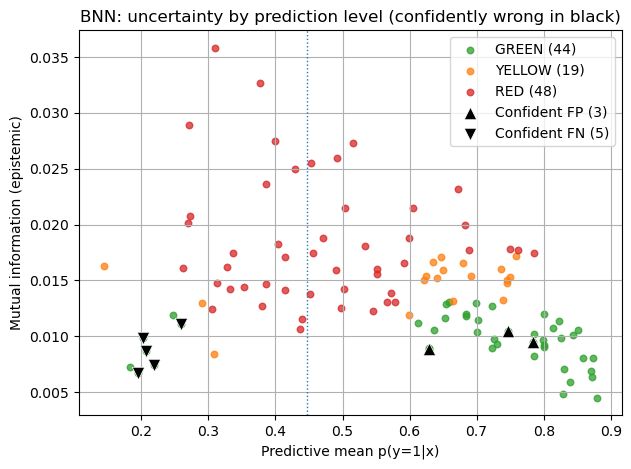

In [59]:
cols = {"RED":"tab:red","YELLOW":"tab:orange","GREEN":"tab:green"}

plt.figure(figsize=(7,5))
for lab in ["GREEN","YELLOW","RED"]:
    g = df[df["label"]==lab]
    plt.scatter(g["p_mean"], g["mutual_info"], s=22, alpha=0.75,
                c=cols[lab], label=f"{lab} ({len(g)})")

# overlay confidently wrong points
plt.scatter(fp["p_mean"], fp["mutual_info"], c="k", s=80, marker="^",
            label=f"Confident FP ({len(fp)})", zorder=6, edgecolor="white", linewidths=0.5)
plt.scatter(fn["p_mean"], fn["mutual_info"], c="k", s=80, marker="v",
            label=f"Confident FN ({len(fn)})", zorder=6, edgecolor="white", linewidths=0.5)

plt.axvline(thr, linestyle=":", linewidth=1)
plt.xlabel("Predictive mean p(y=1|x)")
plt.ylabel("Mutual information (epistemic)")
plt.title("BNN: uncertainty by prediction level (confidently wrong in black)")
plt.legend(); plt.grid(True); plt.show()

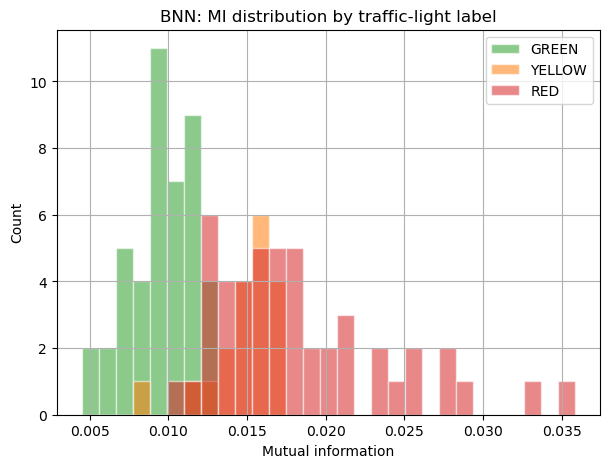


Top confidently wrong FPs:
        p_mean  mutual_info     ci_lo     ci_hi  y_true  pred@thr
193  0.783728     0.009515  0.644831  0.872581       0         1
126  0.746926     0.010428  0.606368  0.855653       0         1
450  0.628432     0.008829  0.497170  0.738062       0         1

Top confidently wrong FNs:
        p_mean  mutual_info     ci_lo     ci_hi  y_true  pred@thr
448  0.194428     0.006673  0.119856  0.299120       1         0
147  0.202527     0.009806  0.114336  0.323173       1         0
411  0.207489     0.008638  0.128954  0.331267       1         0
498  0.219067     0.007418  0.133586  0.335306       1         0
176  0.259345     0.011089  0.154471  0.404986       1         0


In [60]:
bins = np.linspace(df["mutual_info"].min(), df["mutual_info"].max(), 30)

plt.figure(figsize=(7,5))
for lab in ["GREEN","YELLOW","RED"]:
    g = df.loc[df["label"]==lab, "mutual_info"].values
    plt.hist(g, bins=bins, alpha=0.55, label=lab,
             color=cols[lab], edgecolor='white')
plt.xlabel("Mutual information"); plt.ylabel("Count")
plt.title("BNN: MI distribution by traffic-light label")
plt.legend(); plt.grid(True); plt.show()

cols_show = ["p_mean","mutual_info","ci_lo","ci_hi","y_true","pred@thr"]
print("\nTop confidently wrong FPs:\n", fp.sort_values("p_mean", ascending=False)[cols_show].head(10))
print("\nTop confidently wrong FNs:\n", fn.sort_values("p_mean", ascending=True)[cols_show].head(10))

In [61]:
mi = triage_df["mutual_info"].values
print({
    "min": float(mi.min()),
    "q25": float(np.quantile(mi,0.25)),
    "median": float(np.quantile(mi,0.50)),
    "q75": float(np.quantile(mi,0.75)),
    "q80": float(np.quantile(mi,0.80)),
    "q90": float(np.quantile(mi,0.90)),
    "max": float(mi.max()),
})

{'min': 0.004496067762374878, 'q25': 0.010398149490356445, 'median': 0.013174295425415039, 'q75': 0.016831696033477783, 'q80': 0.01745438575744629, 'q90': 0.021483242511749268, 'max': 0.0358317494392395}


In [62]:
def prior_predictive_logit_std(in_dim, hidden_sizes, pi=0.5, s1=1.0, s2=0.1, n=256, S=200):
    # random standardized inputs
    X = torch.randn(n, in_dim)
    sizes = [in_dim] + list(hidden_sizes) + [1]

    def sample_linear(in_f, out_f):
        # mixture: choose component per weight, then sample N(0, sigma^2)
        choose = torch.rand(out_f, in_f) < pi
        sig = torch.where(choose, torch.full_like(choose, s1, dtype=torch.float32),
                                   torch.full_like(choose, s2, dtype=torch.float32)).float()
        W = torch.randn(out_f, in_f) * sig
        b_choose = torch.rand(out_f) < pi
        b_sig = torch.where(b_choose, torch.full_like(b_choose, s1, dtype=torch.float32),
                                       torch.full_like(b_choose, s2, dtype=torch.float32)).float()
        b = torch.randn(out_f) * b_sig
        return W, b

    logits = []
    for _ in range(S):
        h = X.clone()
        for i in range(len(sizes)-2):
            W,b = sample_linear(sizes[i], sizes[i+1])
            h = torch.relu(h @ W.T + b)
        W,b = sample_linear(sizes[-2], sizes[-1])
        z = (h @ W.T + b).squeeze(1)
        logits.append(z.detach().numpy())
    logits = np.stack(logits, 0)             # (S, n)
    return logits.std(axis=0).mean(), logits.mean(), (logits.min(), logits.max())

mstd, mmean, mm = prior_predictive_logit_std(in_dim=X_train.shape[1], hidden_sizes=(256,128))
print("Prior predictive: mean logit std ~", mstd, "mean logit ~", mmean, "range", mm)

Prior predictive: mean logit std ~ 235.19594 mean logit ~ 3.226663 range (np.float32(-1087.3641), np.float32(1234.3444))


In [63]:
mdl_name = 'Bayesian NN'  # or 'Bayesian NN (tuned)' etc.
mdl = fitted_models[mdl_name]

y_true = np.asarray(y_test).astype(int)
p_hat  = all_model_predictions[mdl_name]['y_pred_prob']  # mean p(y=1)

# thresholds for "high certainty"
hi = 0.70
lo = 0.27

idx = X_test.index if hasattr(X_test, 'index') else np.arange(len(y_true))
df = pd.DataFrame({
    'idx': idx,
    'y_true': y_true,
    'p_hat':  p_hat
})
df['pred'] = (df['p_hat'] >= 0.5).astype(int)

# high-confidence mistakes
fp_hi = df[(df['y_true']==0) & (df['p_hat']>=hi)]
fn_hi = df[(df['y_true']==1) & (df['p_hat']<=lo)]

print(f"High-confidence False Positives (y=0, p̂≥{hi}): {len(fp_hi)}")
print(fp_hi.sort_values('p_hat', ascending=False))

print(f"\nHigh-confidence False Negatives (y=1, p̂≤{lo}): {len(fn_hi)}")
print(fn_hi.sort_values('p_hat', ascending=True))

High-confidence False Positives (y=0, p̂≥0.7): 4
     idx  y_true     p_hat  pred
109  193       0  0.784873     1
29    35       0  0.781279     1
46    30       0  0.748044     1
82   126       0  0.737998     1

High-confidence False Negatives (y=1, p̂≤0.27): 7
    idx  y_true     p_hat  pred
87   72       1  0.145761     0
54  448       1  0.189367     0
34  147       1  0.197811     0
1   411       1  0.200934     0
14  498       1  0.214686     0
40  424       1  0.254457     0
48  176       1  0.265230     0
